In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import random as rd
import math
import os
import torch
from pathlib import Path
import glob
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint,EarlyStopping
from torchmetrics import MeanSquaredError
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [52]:
def problem_generator(num_of_clients,dim_size=4,time_length=96,util_demand_relation='linear'):##random,quadratic,linear
    clients_list=[]
    size=dim_size+time_length+4 ##demands_per_dim,time_s,time_e,time_interval,utility,chosen or not
    lin_comb=np.random.rand(dim_size)*3+1
    
    for index in range(num_of_clients):
        client=np.zeros(size)
        for dim in range(dim_size):
            client[dim]=np.random.randint(10,50)
        s_time=rd.randint(1,time_length)
        e_time=rd.randint(s_time+1,time_length+1)
        client[dim_size]=s_time
        client[dim_size+1]=e_time  ##end_time excluded
        client[dim_size+1+s_time:dim_size+1+e_time]=np.ones(e_time-s_time)
        if util_demand_relation=='linear':
            client[-2]=np.dot(lin_comb,client[:dim_size]) #utility
        elif util_demand_relation=='quadratic':
            client[-2]=np.dot(lin_comb,client[:dim_size])
        elif util_demand_relation=='random':
            client[-2]=np.random.rand()*300 +100
        clients_list.append(client)
    time_slot_capacity=np.random.randint(num_of_clients*0.3*20,num_of_clients*0.6*30,(dim_size,time_length))
    ufp_model=gp.Model()
    opt_choice=ufp_model.addVars(num_of_clients,vtype=GRB.BINARY,name="opt_choice")
    constr=ufp_model.addConstrs((gp.quicksum([opt_choice[index]*clients_list[index][dim]*
                                              clients_list[index][dim_size+1+time]
                                              for index in range(num_of_clients)])<=time_slot_capacity[dim][time-1]
                                              for dim in range(dim_size) for time in range(1,time_length+1)),name="c")
    objective=ufp_model.setObjective(gp.quicksum([opt_choice[i]*clients_list[i][-2] for i in range(num_of_clients)]),GRB.MAXIMIZE)
    ufp_model.optimize()
    answer=np.array([item.x for item in ufp_model.getVars()])
    clients_list=np.stack(clients_list)
    clients_list[:,-1]=answer
    return np.stack(clients_list),time_slot_capacity,answer

In [53]:
cl_list,t_slot,ans=problem_generator(1000,6,30,'random')

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 1000 columns and 49944 nonzeros
Model fingerprint: 0xe740456c
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [1e+02, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+03, 2e+04]
Found heuristic solution: objective 199287.16329
Presolve removed 131 rows and 138 columns
Presolve time: 0.01s
Presolved: 49 rows, 862 columns, 17237 nonzeros
Variable types: 0 continuous, 862 integer (862 binary)
Found heuristic solution: objective 211279.30314

Root relaxation: objective 2.213907e+05, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [61]:
def problem_grouping(clients_list,time_slot,gr_util,gr_time):##grouping by utility,then by time_slot_length 
    num_of_clients=len(clients_list)
    num_of_dims=len(time_slot)
    time_slot_min=np.zeros((num_of_dims))
    time_slot_av=np.zeros((num_of_dims))
    time_slot_max=np.zeros((num_of_dims))
    max_cap=time_slot.max()
    for dim in range(num_of_dims):
        time_slot_min[dim]=time_slot[dim].min()
        time_slot_av[dim]=time_slot[dim].mean()
        time_slot_max[dim]=time_slot[dim].mean()
    min_av_max_caps=np.concatenate((time_slot_min,time_slot_av,time_slot_max))
    av_cap_bytime=time_slot.mean(axis=0)/max_cap
    ##Normalizing utilities by max utility,demands in each dimension by min capacity
    max_util=clients_list[:,-2].max()
    clients_list[:,-2]/=max_util#normalizing utilities
    for dim in range(num_of_dims):
        clients_list[:,dim]/=time_slot_min[dim]
    total_demand=clients_list[:,0].sum()#sum of demands of the first dimension normalized by min capacity of the first dimension
    #normalizing time capacities
    time_slot_min/=max_cap
    time_slot_av/=max_cap
    time_slot_max/=max_cap
    ##Grouping by utilities
    util_groups=[]
    min_util = clients_list[:,-2].min()
    av_util=clients_list[:,-2].mean()
    x=(1/min_util)**(1/gr_util)
    print(1/min_util)
    steps=np.zeros(gr_util+1)
    for i in range(steps.size):
        steps[i]=x**i
    print('x ',x)
    steps[-1]+=1
    print(steps)
    for i in range(gr_util-1):
        bool_idx = (clients_list[:,-2] <= min_util*steps[gr_util-i]) & (clients_list[:,-2] > min_util*steps[gr_util-1-i])
        util_groups.append(clients_list[np.where(bool_idx)[0]])
    bool_idx = (clients_list[:,-2] <= min_util*steps[1]) & (clients_list[:,-2] >= min_util*steps[0])
    util_groups.append(clients_list[np.where(bool_idx)[0]])
    ##Grouping by time_length
    final_groups=[]
    for i in range(gr_util):
        if(util_groups[i].size>0):
            group_time_lengths=util_groups[i][:,num_of_dims+1]-util_groups[i][:,num_of_dims]
            min_time_len=np.min(group_time_lengths)
            max_time_len=np.max(group_time_lengths)
            steps=np.linspace(min_time_len,max_time_len,gr_time+1)
            for j in range(gr_time-1):
                bool_idx = (group_time_lengths >= steps[j]) & (group_time_lengths < steps[j+1])
                final_groups.append(util_groups[i][np.where(bool_idx)[0]])
            bool_idx = (group_time_lengths >= steps[-2]) & (group_time_lengths <= steps[-1])
            final_groups.append(util_groups[i][np.where(bool_idx)[0]])
        else:
            for _ in range(gr_time):
                final_groups.append(util_groups[i])
    return final_groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util

In [4]:
def problem_grouping_1(clients_list,time_slot,gr_util):##grouping only by utility
    num_of_clients=len(clients_list)
    num_of_dims=len(time_slot)
    time_slot_min=np.zeros((num_of_dims))
    time_slot_av=np.zeros((num_of_dims))
    time_slot_max=np.zeros((num_of_dims))
    max_cap=time_slot.max()
    for dim in range(num_of_dims):
        time_slot_min[dim]=time_slot[dim].min()
        time_slot_av[dim]=time_slot[dim].mean()
        time_slot_max[dim]=time_slot[dim].mean()
    min_av_max_caps=np.concatenate((time_slot_min,time_slot_av,time_slot_max))
    av_cap_bytime=time_slot.mean(axis=0)/max_cap
    ##Normalizing utilities by max utility,demands in each dimension by min capacity
    max_util=clients_list[:,-2].max()
    clients_list[:,-2]/=max_util#normalizing utilities
    for dim in range(num_of_dims):
        clients_list[:,dim]/=time_slot_min[dim]
    total_demand=clients_list[:,0].sum()#sum of demands of the first dimension normalized by min capacity of the first dimension
    #normalizing time capacities
    time_slot_min/=max_cap
    time_slot_av/=max_cap
    time_slot_max/=max_cap
    ##Grouping by utilities
    util_groups=[]
    min_util = clients_list[:,-2].min()
    av_util=clients_list[:,-2].mean()
    x=(1/min_util)**(1/gr_util)
    steps=np.zeros(gr_util+1)
    for i in range(steps.size):
        steps[i]=x**i
    steps[-1]+=1
    for i in range(gr_util-1):
        bool_idx = (clients_list[:,-2] <= min_util*steps[gr_util-i]) & (clients_list[:,-2] > min_util*steps[gr_util-1-i])
        util_groups.append(clients_list[np.where(bool_idx)[0]])
    bool_idx = (clients_list[:,-2] <= min_util*steps[1]) & (clients_list[:,-2] >= min_util*steps[0])
    util_groups.append(clients_list[np.where(bool_idx)[0]])
    return util_groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util

In [5]:
def data_preprocess(groups,num_of_clients,num_of_dims,time_length,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util):
    length=len(groups)
    inputs=np.zeros((length+1,3*num_of_dims+time_length+2))
    labels=np.zeros((length+1,2))
    for i,group in enumerate(groups):
        if group.size>0:
            inputs[i][:num_of_dims]=np.min(group[:,:num_of_dims],axis=0)#minimum demand
            inputs[i][num_of_dims:2*num_of_dims]=np.mean(group[:,:num_of_dims],axis=0)#average demand
            inputs[i][2*num_of_dims:3*num_of_dims]=np.max(group[:,:num_of_dims],axis=0)#maximum demand
            inputs[i][3*num_of_dims:3*num_of_dims+time_length]=np.sum(group[:,num_of_dims+2:num_of_dims+2+time_length],axis=0)/num_of_clients#average time_occupancy
            inputs[i][-2]=np.mean(group[:,-2])#average utility
            inputs[i][-1]=group.shape[0]/num_of_clients#what part of clients is in this group
            labels[i][0]=np.sum(group[:,-1])/num_of_clients#what part is selected in the final answer 
            if group[np.where(group[:,-1]==1)].size>0:
                labels[i][1]=group[np.where(group[:,-1]==1)][:,0].sum()/total_demand#total demand of selected clients/total demand of the first dimension
    inputs[-1][:3*num_of_dims]=min_av_max_caps
    inputs[-1][3*num_of_dims:3*num_of_dims+time_length]=av_cap_bytime
    inputs[-1][-2]=min_util
    inputs[-1][-1]=av_util
    labels[-1][0]=1-labels[:,0].sum()
    labels[-1][1]=1-labels[:,1].sum()
    return inputs,labels

In [6]:
def file_maker2(filename,num_of_clients,num_of_dims,time_length,gr_util,gr_time):
    clients_list,time_slot,answer=problem_generator(num_of_clients,num_of_dims,time_length)
    groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util=problem_grouping(clients_list,time_slot,gr_util,gr_time)
    inputs,labels=data_preprocess(groups,num_of_clients,num_of_dims,time_length,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util)
    np.save('inputs2//'+filename,inputs)
    new_file='solution_'+filename
    np.save('labels2//'+new_file,labels)

In [ ]:
for i in range(10000):
    file_maker("ufp_"+str(i),100,6,30,5,3)

In [7]:
class DataSetMaker(Dataset):
    def __init__(self):
        self.files=list(glob.glob('inputs/*.npy'))
        self.labelFiles = list(glob.glob('labels/*.npy'))
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        inputs=np.float32(np.load(self.files[idx]))
        labels=np.float32(np.load(self.labelFiles[idx]).astype(np.float32))
        return inputs,labels

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [9]:
dataset=DataSetMaker()

In [10]:
train_set,valid_set,test_set=random_split(dataset,[8000,1000,1000])

In [11]:
train_loader = DataLoader(train_set, batch_size=128,shuffle=True,drop_last=True)
val_loader = DataLoader(valid_set, batch_size=1)
test_loader = DataLoader(test_set, batch_size=1)

In [12]:
def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values

In [13]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        
        return o

In [14]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention part
        attn_out = self.self_attn(x)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [15]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [16]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [17]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x,add_positional_encoding=False):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x)
        x = self.output_net(x)
        x = F.softmax(x, dim=-2)
        #x = F.softmax(x, dim=1)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        
        return [optimizer], [{'scheduler': lr_scheduler,
                              'interval': 'epoch'}]

        
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError
        
    def on_train_epoch_end(self):
        raise NotImplementedError

In [18]:
class  KnapsackPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        inp_data, labels = batch
        # Perform prediction and calculate loss and accuracy
        #scaling_factors=torch.tensor([10,1],device=device)
        preds = self.forward(inp_data)
        loss1 = F.l1_loss(preds[:,:,0],labels[:,:,0])
        loss2 = F.l1_loss(preds[:,:,1],labels[:,:,1])
        loss=loss1+loss2
        # Logging
        self.log(f"{mode}_loss",loss)
        self.log(f"{mode}_loss1",loss1)
        self.log(f"{mode}_loss2",loss2)
        return loss

    def training_step(self, batch, batch_idx):
        loss= self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")
        
    def on_train_epoch_end(self):
        batch = next(iter(train_loader))
        x, _ = batch
        x=x.to(device)
        # Forward pass to get predictions
        predictions = self.forward(x)
        
        # Print predictions
        print("Predictions:", predictions[[-1]].to('cpu').detach().numpy())

In [19]:
CHECKPOINT_PATH="C:\\Users\\zhira\\CSIE_PYTHON_PROJECTS\\UfpLast"

In [20]:
def train_knapsack(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "UfpCheckPointTwo")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(callbacks=[ModelCheckpoint(dirpath=root_dir,filename='UfpCheckPointTwo',save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor(logging_interval='epoch'),
                                    EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=20, verbose=False, mode="min")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=150,
                         gradient_clip_val=1,
                         log_every_n_steps=10)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(root_dir, "UfpCheckPointTwo.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = KnapsackPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = KnapsackPredictor(max_iters=trainer.max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad}")

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=1)
    test_result = trainer.test(model, test_loader, verbose=1)

    model = model.to(device)
    return model

In [21]:
knapsack_model =                  train_knapsack(input_dim=50,
                                                 model_dim=150,
                                                 num_heads=2,
                                                 num_classes=2,
                                                 num_layers=2,
                                                 dropout=0.0,
                                                 lr=1e-4,
                                                 warmup=20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\zhira\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.011880963109433651    │
│        test_loss1         │   0.005675081163644791    │
│        test_loss2         │   0.006205877289175987    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\zhira\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.011961272917687893    │
│        test_loss1         │   0.005741175729781389    │
│        test_loss2         │   0.006220105104148388    │
└───────────────────────────┴───────────────────────────┘

In [22]:
def sample_maker(num_of_clients,num_of_dims,time_length,gr_util,gr_time):
    clients_list,time_slot,answer=problem_generator(num_of_clients,num_of_dims,time_length,'linear')
    groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util=problem_grouping(clients_list,time_slot,gr_util,gr_time)
    inputs,labels=data_preprocess(groups,num_of_clients,num_of_dims,time_length,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util)
    return inputs,labels

In [23]:
inps,labs=sample_maker(100,6,30,5,3)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5478 nonzeros
Model fingerprint: 0x6fe9cfff
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 28475.862180
Presolve removed 122 rows and 13 columns
Presolve time: 0.01s
Presolved: 58 rows, 87 columns, 2478 nonzeros
Variable types: 0 continuous, 87 integer (87 binary)
Found heuristic solution: objective 30900.943324

Root relaxation: objective 3.227327e+04, 26 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

In [24]:
inps=torch.from_numpy(np.float32(inps[None,:])).to(device)

In [25]:
pred=knapsack_model(inps)

In [26]:
pred.shape

torch.Size([1, 16, 2])

In [27]:
pred=pred.cpu().detach().numpy().squeeze()

In [28]:
pred.shape

(16, 2)

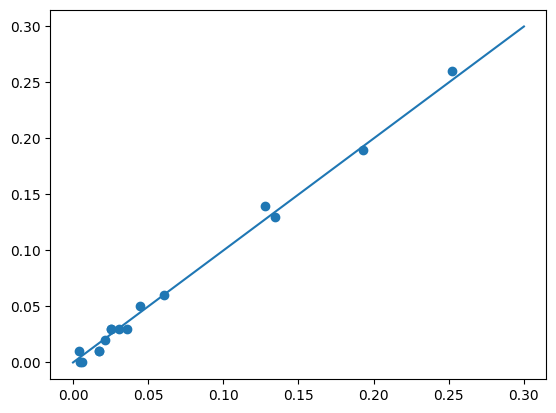

In [29]:
plt.scatter(pred[:,0],labs[:,0])
plt.plot([0,0.3],[0,0.3])

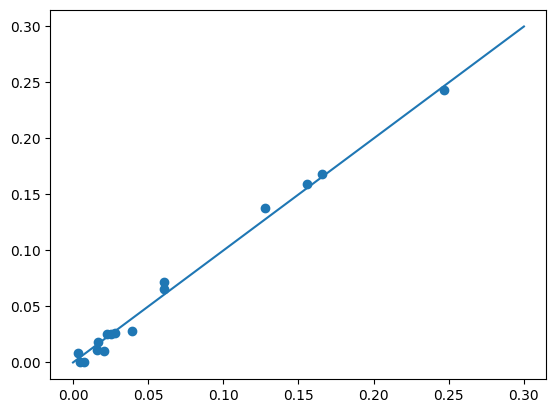

In [30]:
plt.scatter(pred[:,1],labs[:,1])
plt.plot([0,0.3],[0,0.3])

y_pred[0][i]-what part of the group is in the final answer
y_pred[1][i]-(total demand of selected items in the first dimension)/(total demand of all clients in the first dimension)

In [31]:
num_of_clients=100
num_of_dims=6
time_length=30
gr_util=5
gr_time=3

In [32]:
def problem_maker(num_of_clients,num_of_dims,time_length,gr_util,gr_time):
    clients_list,time_slot,answer=problem_generator(num_of_clients,num_of_dims,time_length,'linear')
    groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util=problem_grouping(clients_list,time_slot,gr_util,gr_time)
    return clients_list,time_slot,answer,groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util

In [33]:
clients_list,time_slot,answer,groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util=problem_maker(num_of_clients,num_of_dims,time_length,gr_util,gr_time)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4800 nonzeros
Model fingerprint: 0x4c85f4a7
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 37249.228773
Presolve removed 135 rows and 11 columns
Presolve time: 0.00s
Presolved: 45 rows, 89 columns, 1580 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
Found heuristic solution: objective 41892.788421

Root relaxation: objective 4.518934e+04, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

In [34]:
inputs,labels=data_preprocess(groups,num_of_clients,num_of_dims,time_length,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util)

In [35]:
inputs=torch.from_numpy(np.float32(inputs[None,:])).to(device)

In [36]:
y_pred=knapsack_model(inputs)

In [37]:
y_pred=y_pred.squeeze()

In [38]:
def selection_algorithm(clients_list,time_slot,groups,total_demand,y_pred):
    num_of_changes=10
    num_of_dims=time_slot.shape[0]
    if type(y_pred)!=np.ndarray:
        prediction=y_pred.cpu().detach().numpy()
    else:
        prediction=y_pred
    length=clients_list.shape[0]
    time_length=time_slot.shape[1]
    time_slot_min=np.zeros(num_of_dims)
    for dim in range(num_of_dims):
        time_slot_min[dim]=time_slot[dim].min()
    sum_demands=prediction[:,1]*total_demand #(total_demand)<-total demand of selected items in the first dimension
    violated_total_utility=0
    violated_selected_items=[]
    final_total_utility=0
    final_selected_items=[]
    for step in range(100):
        total_utility=0
        selected_items=[]
        for i,group in enumerate(groups):
            if(group.size>0):
                max_res=0
                best_vec=np.array([])
                curr_demand=0
                group_util_sum=np.sum(group[:,-2])
                #prob_vec=np.array([item[-2]/group_util_sum for item in group])
                prob_vec_uniform=np.ones(group.shape[0])/group.shape[0]
                for _ in range(10):
                    sel_size=min(math.ceil(prediction[i][0]*length),group.shape[0])
                    selection=np.random.choice(range(group.shape[0]),sel_size,replace=False,p=prob_vec_uniform)
                    sel_vec=group[selection]
                    util_sum=np.sum(sel_vec[:,-2])
                    d_sum=np.sum(sel_vec[:,0]) #total demand of selected items in the first dimension
                    if np.abs(d_sum-sum_demands[i])<=0.1*sum_demands[i] and util_sum>max_res:
                        max_res=util_sum
                        best_vec=sel_vec
                        curr_demand=d_sum
                if best_vec.size>0:
                    total_utility+=max_res
                    for item in best_vec:
                        selected_items.append(item)
        is_correct=np.stack([sum([selected_items[index][dim]*time_slot_min[dim]*selected_items[index][num_of_dims+1+time] for index in range(len(selected_items))])<=time_slot[dim][time-1]
                                                  for dim in range(num_of_dims) for time in range(1,time_length+1)])
        if all(is_correct):
            if final_total_utility<total_utility:
                final_selected_items=selected_items.copy()
                final_total_utility=total_utility
        else:
            if violated_total_utility<total_utility:
                violated_selected_items=selected_items.copy()
                violated_total_utility=total_utility
                correct=np.copy(is_correct)
    if final_total_utility>0:
        return np.stack(final_selected_items),final_total_utility
    while not all(correct):
            min_utility=2
            min_item_index=0
            indices=np.where(correct==False)[0]
            dims_f=indices%6
            times_f=indices//6+1
            time_indices=num_of_dims+1+times_f
            for item in range(len(violated_selected_items)):
                x=violated_selected_items[item]
                if any(x[time_indices]==1):
                    if(x[-2]<min_utility):
                        min_utility=x[-2]
                        min_item_index=item
            violated_selected_items.pop(min_item_index)
            violated_total_utility=sum([item[-2] for item in violated_selected_items])
            correct=np.stack([sum([violated_selected_items[index][dim]*time_slot_min[dim]*violated_selected_items[index][num_of_dims+1+time] for index in range(len(violated_selected_items))])<=time_slot[dim][time-1]
                                              for dim in range(num_of_dims) for time in range(1,time_length+1)])
            if all(correct):
                break
    return np.stack(violated_selected_items),violated_total_utility

In [39]:
def selection_algorithm2(clients_list,time_slot,groups,total_demand,y_pred):
    if type(y_pred)!=np.ndarray:
        prediction=y_pred.cpu().detach().numpy()
    else:
        prediction=y_pred
    num_of_dims=time_slot.shape[0]
    length=clients_list.shape[0]
    time_length=time_slot.shape[1]
    time_slot_min = time_slot.min(axis=1)
    
    sum_demands=prediction[:,1]*total_demand #(total_demand)<-total demand of selected items in the first dimension
    final_total_utility=0
    final_selected_items=[]
    for step in range(100):
        total_utility=0
        selected_items=[]
        for i,group in enumerate(groups):
            if(group.size>0):
                max_res=0
                best_vec=np.array([])
                curr_demand=0
                group_util_sum=np.sum(group[:,-2])
                #prob_vec=np.array([item[-2]/group_util_sum for item in group])
                prob_vec_uniform=np.ones(group.shape[0])/group.shape[0]
                for _ in range(10):
                    sel_size=min(math.ceil(prediction[i][0]*length),group.shape[0])
                    selection=np.random.choice(range(group.shape[0]),sel_size,replace=False,p=prob_vec_uniform)
                    sel_vec=group[selection]
                    util_sum=np.sum(sel_vec[:,-2])
                    d_sum=np.sum(sel_vec[:,0]) #total demand of selected items in the first dimension
                    if util_sum>max_res and np.abs(d_sum-sum_demands[i])<=0.1*sum_demands[i]:#0.05
                        max_res=util_sum
                        best_vec=sel_vec
                        curr_demand=d_sum
                if best_vec.size>0:
                    total_utility+=max_res
                    selected_items.extend(best_vec)
                    
        is_correct=np.stack([sum([selected_items[index][dim]*time_slot_min[dim]*selected_items[index][num_of_dims+1+time] for index in range(len(selected_items))])<=time_slot[dim][time-1]
                                                  for dim in range(num_of_dims) for time in range(1,time_length+1)])
        while not all(is_correct) and total_utility>final_total_utility:
            min_utility=2
            min_item_index=0
            indices=np.where(is_correct==False)[0]
            dims_f=indices%6
            times_f=indices//6+1
            time_indices=num_of_dims+1+times_f
            for item in range(len(selected_items)):
                x=selected_items[item]
                if any(x[time_indices]==1):
                    if(x[-2]<min_utility):
                        min_utility=x[-2]
                        min_item_index=item
            selected_items.pop(min_item_index)
            total_utility=sum([item[-2] for item in selected_items])
            is_correct=np.stack([sum([selected_items[index][dim]*time_slot_min[dim]*selected_items[index][num_of_dims+1+time] for index in range(len(selected_items))])<=time_slot[dim][time-1]
                                              for dim in range(num_of_dims) for time in range(1,time_length+1)])
            if all(is_correct):
                break
        if final_total_utility<total_utility:
            final_selected_items=selected_items.copy()
            final_total_utility=total_utility
    return np.stack(final_selected_items),final_total_utility

In [40]:
def selection_algorithm3(clients_list, time_slot, groups, total_demand, y_pred):
    if type(y_pred) != np.ndarray:
        prediction = y_pred.cpu().detach().numpy()
    else:
        prediction = y_pred

    num_of_dims = time_slot.shape[0]
    length = clients_list.shape[0]
    time_length = time_slot.shape[1]
    time_slot_min = time_slot.min(axis=1)
    
    sum_demands = prediction[:, 1] * total_demand 

    final_total_utility = 0
    final_selected_items = []

    for _ in range(10):
        total_utility = 0
        selected_items = []
        rand_perm = np.random.permutation(len(groups))
        
        for gr_num in rand_perm:
            group = groups[gr_num]
            if group.size > 0:
                max_res = 0
                best_vec = np.array([])

                sel_size = min(math.ceil(prediction[gr_num][0] * length), group.shape[0])
                indexes = set(range(sel_size))
                chosen = set()
                invalid_indices = set()

                for _ in range(10):
                    sel_vec = []

                    for index in range(sel_size):
                        for _ in range(10):
                            available_indexes = list(indexes - chosen - invalid_indices)
                            if not available_indexes:
                                break
                            
                            choice = np.random.choice(available_indexes)
                            
                            curr_item = group[choice]
                            temp_selected_items = selected_items + [curr_item]

                            sums = np.array([sum([item[dim] * time_slot_min[dim] * item[num_of_dims + 1 + time] for item in temp_selected_items])
                                             for dim in range(num_of_dims) for time in range(1, time_length + 1)])

                            is_correct = sums <= time_slot[:,:time_length].flatten()

                            if all(is_correct):
                                sel_vec.append(curr_item)
                                chosen.add(choice)
                                break
                            else:
                                invalid_indices.add(choice)

                    if sel_vec:
                        sel_vec = np.array(sel_vec)
                        util_sum = sel_vec[:, -2].sum()
                        d_sum = sel_vec[:, 0].sum()

                        if util_sum > max_res and np.abs(d_sum - sum_demands[gr_num]) <= 0.2 * sum_demands[gr_num] :
                            max_res = util_sum
                            best_vec = sel_vec

                if best_vec.size > 0:
                    total_utility += max_res
                    selected_items.extend(best_vec)

        if final_total_utility < total_utility:
            final_total_utility = total_utility
            final_selected_items = selected_items

    return np.stack(final_selected_items), final_total_utility

In [41]:
import time

In [42]:
start=time.time()
sel,ut=selection_algorithm3(clients_list,time_slot,groups,total_demand,y_pred)
print(time.time()-start)

2.4917726516723633


In [43]:
ut

52.87686481239159

In [44]:
start=time.time()
sel_it,util=selection_algorithm(clients_list,time_slot,groups,total_demand,y_pred)
print(time.time()-start)

1.8134148120880127


In [45]:
util

48.81700237740943

In [46]:
start=time.time()
sel_it2,util2=selection_algorithm2(clients_list,time_slot,groups,total_demand,y_pred)
print(time.time()-start)

2.85866117477417


In [47]:
util2

48.76954696960801

In [48]:
clients_list[answer==1][:,-2].sum()

55.155159140808976

In [49]:
count=100

In [50]:
alg_results=np.zeros(count)
alg_results_2=np.zeros(count)
alg_results_3=np.zeros(count)
gur_results=np.zeros(count)

In [51]:
for i in range(count):
    print(f'-------------{i}--------------')
    clients_list,time_slot,answer,groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util=problem_maker(num_of_clients,num_of_dims,time_length,gr_util,gr_time)
    inputs,labels=data_preprocess(groups,num_of_clients,num_of_dims,time_length,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util)
    inputs=torch.from_numpy(np.float32(inputs[None,:])).to(device)
    y_pred=knapsack_model(inputs).squeeze()
    _,util=selection_algorithm(clients_list,time_slot,groups,total_demand,y_pred)
    _,util2=selection_algorithm2(clients_list,time_slot,groups,total_demand,y_pred)
    _,util3=selection_algorithm2(clients_list,time_slot,groups,total_demand,y_pred)
    alg_results[i]=util
    alg_results_2[i]=util2
    alg_results_3[i]=util3
    gur_results[i]=clients_list[answer==1][:,-2].sum()

-------------0--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5244 nonzeros
Model fingerprint: 0xac811106
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 30664.041509
Presolve removed 131 rows and 12 columns
Presolve time: 0.00s
Presolved: 49 rows, 88 columns, 1835 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 32313.037781

Root relaxation: objective 3.445935e+04, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5172 nonzeros
Model fingerprint: 0x125a2604
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 33448.210548
Presolve removed 131 rows and 3 columns
Presolve time: 0.00s
Presolved: 49 rows, 97 columns, 1851 nonzeros
Variable types: 0 continuous, 97 integer (97 binary)
Found heuristic solution: objective 36246.102927

Root relaxation: objective 3.748888e+04, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 37488.8843    0    5 36246.1029 37488.8843  3.43%     -    0s
H    0     0                    36908.933


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 42728.8171    0    6 40959.1135 42728.8171  4.32%     -    0s
H    0     0                    42229.064548 42728.8171  1.18%     -    0s
H    0     0                    42333.801537 42728.8171  0.93%     -    0s
H    0     0                    42507.033580 42728.8171  0.52%     -    0s
     0     0 42718.7622    0    8 42507.0336 42718.7622  0.50%     -    0s
     0     0 42718.7622    0    6 42507.0336 42718.7622  0.50%     -    0s
     0     0 42718.7622    0    8 42507.0336 42718.7622  0.50%     -    0s
     0     0 42679.3840    0   10 42507.0336 42679.3840  0.41%     -    0s
     0     0 42679.2967    0    8 42507.0336 42679.2967  0.41%     -    0s
     0     0 42678.6680    0    8 42507.0336 42678.6680  0.40%     -    0s
     0     0 42678.6680    0    8 42507.0336 42678.6680  0.40%     -    0s
     0     0 42667.6521


CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5496 nonzeros
Model fingerprint: 0xc3adb7d3
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 31031.336488
Presolve removed 126 rows and 8 columns
Presolve time: 0.00s
Presolved: 54 rows, 92 columns, 2138 nonzeros
Variable types: 0 continuous, 92 integer (92 binary)
Found heuristic solution: objective 32999.652156

Root relaxation: objective 3.653860e+04, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 36538.5986    0    4

     0     0 30815.2324    0   12 30696.9421 30815.2324  0.39%     -    0s
     0     0 30815.2324    0   11 30696.9421 30815.2324  0.39%     -    0s
     0     0 30815.2324    0   10 30696.9421 30815.2324  0.39%     -    0s
     0     0 30815.2324    0   11 30696.9421 30815.2324  0.39%     -    0s
     0     0 30815.2324    0   12 30696.9421 30815.2324  0.39%     -    0s
     0     0 30813.0512    0   13 30696.9421 30813.0512  0.38%     -    0s
     0     0 30809.8005    0   12 30696.9421 30809.8005  0.37%     -    0s
     0     0 30808.9945    0   12 30696.9421 30808.9945  0.37%     -    0s
     0     0 30808.9945    0   14 30696.9421 30808.9945  0.37%     -    0s
     0     0 30808.9945    0   14 30696.9421 30808.9945  0.37%     -    0s
     0     0 30800.3585    0    9 30696.9421 30800.3585  0.34%     -    0s
     0     0 30800.1906    0    9 30696.9421 30800.1906  0.34%     -    0s
     0     2 30800.1906    0    9 30696.9421 30800.1906  0.34%     -    0s
*  275   113             

Found heuristic solution: objective 38512.422336
Presolve removed 134 rows and 7 columns
Presolve time: 0.00s
Presolved: 46 rows, 93 columns, 1537 nonzeros
Variable types: 0 continuous, 93 integer (93 binary)
Found heuristic solution: objective 40425.662370

Root relaxation: objective 4.279426e+04, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 42794.2624    0    5 40425.6624 42794.2624  5.86%     -    0s
H    0     0                    41831.451338 42794.2624  2.30%     -    0s
H    0     0                    42528.966681 42794.2624  0.62%     -    0s
     0     0 42787.0586    0    7 42528.9667 42787.0586  0.61%     -    0s
     0     0 42787.0586    0    5 42528.9667 42787.0586  0.61%     -    0s
H    0     0                    42575.661053 42787.0586  0.50%     -    0s
     0     0 42764.1304    0    8 42575.6611 42764.1

     0     0 39695.7464    0   10 39580.0081 39695.7464  0.29%     -    0s
     0     0 39695.7464    0   10 39580.0081 39695.7464  0.29%     -    0s
     0     0 39690.7534    0   10 39580.0081 39690.7534  0.28%     -    0s
     0     0 39677.2115    0   12 39580.0081 39677.2115  0.25%     -    0s
     0     0 39671.1132    0   13 39580.0081 39671.1132  0.23%     -    0s
     0     0 39669.6979    0   13 39580.0081 39669.6979  0.23%     -    0s
     0     0 39669.3429    0   14 39580.0081 39669.3429  0.23%     -    0s
     0     0 39668.1990    0   12 39580.0081 39668.1990  0.22%     -    0s
     0     0 39668.1182    0   12 39580.0081 39668.1182  0.22%     -    0s
     0     0 39664.6227    0   12 39580.0081 39664.6227  0.21%     -    0s
     0     0 39662.5308    0   13 39580.0081 39662.5308  0.21%     -    0s
     0     0 39662.5308    0   14 39580.0081 39662.5308  0.21%     -    0s
     0     0 39661.2228    0   11 39580.0081 39661.2228  0.21%     -    0s
     0     0 39659.9166  

     0     0 35810.0435    0    9 35421.8815 35810.0435  1.10%     -    0s
H    0     0                    35447.331218 35810.0435  1.02%     -    0s
H    0     0                    35560.442807 35800.4035  0.67%     -    0s
     0     0 35788.9080    0   12 35560.4428 35788.9080  0.64%     -    0s
     0     0 35788.2299    0   14 35560.4428 35788.2299  0.64%     -    0s
     0     0 35788.2299    0   14 35560.4428 35788.2299  0.64%     -    0s
     0     0 35787.9462    0   15 35560.4428 35787.9462  0.64%     -    0s
     0     0 35787.5374    0   15 35560.4428 35787.5374  0.64%     -    0s
     0     0 35753.0891    0   14 35560.4428 35753.0891  0.54%     -    0s
     0     0 35753.0891    0    6 35560.4428 35753.0891  0.54%     -    0s
     0     0 35753.0891    0    7 35560.4428 35753.0891  0.54%     -    0s
     0     0 35753.0891    0   12 35560.4428 35753.0891  0.54%     -    0s
     0     0 35753.0891    0   11 35560.4428 35753.0891  0.54%     -    0s
     0     0 35753.0891  

     0     0 34964.7001    0    8 34699.9201 34964.7001  0.76%     -    0s
     0     0 34964.7001    0    6 34699.9201 34964.7001  0.76%     -    0s
H    0     0                    34700.777643 34964.7001  0.76%     -    0s
     0     0 34956.3149    0    7 34700.7776 34956.3149  0.74%     -    0s
     0     0 34911.6690    0   10 34700.7776 34911.6690  0.61%     -    0s
     0     0 34911.6690    0    9 34700.7776 34911.6690  0.61%     -    0s
     0     0 34911.6690    0   10 34700.7776 34911.6690  0.61%     -    0s
     0     0 34909.2362    0   11 34700.7776 34909.2362  0.60%     -    0s
     0     0 34907.1835    0   11 34700.7776 34907.1835  0.59%     -    0s
     0     0 34904.4678    0   11 34700.7776 34904.4678  0.59%     -    0s
H    0     0                    34715.353650 34904.4678  0.54%     -    0s
H    0     0                    34757.612282 34891.8741  0.39%     -    0s
     0     0 34887.8090    0   10 34757.6123 34887.8090  0.37%     -    0s
H    0     0             

     0     0 46934.6662    0   16 46809.9181 46934.6662  0.27%     -    0s
     0     0 46934.6662    0   16 46809.9181 46934.6662  0.27%     -    0s
     0     0 46934.6662    0   17 46809.9181 46934.6662  0.27%     -    0s
     0     0 46934.6662    0   17 46809.9181 46934.6662  0.27%     -    0s
     0     0 46934.6662    0   18 46809.9181 46934.6662  0.27%     -    0s
     0     0 46934.6662    0   17 46809.9181 46934.6662  0.27%     -    0s
     0     0 46931.7350    0   17 46809.9181 46931.7350  0.26%     -    0s
     0     0 46931.0566    0   18 46809.9181 46931.0566  0.26%     -    0s
     0     0 46930.8308    0   18 46809.9181 46930.8308  0.26%     -    0s
     0     0 46929.8520    0   16 46809.9181 46929.8520  0.26%     -    0s
     0     0 46929.7182    0   17 46809.9181 46929.7182  0.26%     -    0s
     0     0 46928.4135    0   18 46809.9181 46928.4135  0.25%     -    0s
     0     0 46927.7991    0   18 46809.9181 46927.7991  0.25%     -    0s
     0     0 46924.2258  

     0     0 36032.9148    0    8 36006.7900 36032.9148  0.07%     -    0s
     0     0 36032.3317    0    9 36006.7900 36032.3317  0.07%     -    0s
     0     0 36031.1616    0    9 36006.7900 36031.1616  0.07%     -    0s
     0     0 36030.2191    0   10 36006.7900 36030.2191  0.07%     -    0s
     0     0 36017.6545    0   10 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0   10 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    3 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    5 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    5 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    5 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    5 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    7 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545    0    7 36006.7900 36017.6545  0.03%     -    0s
     0     0 36017.6545  

Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 33414.334684
Presolve removed 165 rows and 32 columns
Presolve time: 0.00s
Presolved: 15 rows, 68 columns, 392 nonzeros
Variable types: 0 continuous, 68 integer (68 binary)
Found heuristic solution: objective 34762.652351

Root relaxation: objective 3.582591e+04, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 35825.9061    0    3 34762.6524 35825.9061  3.06%     -    0s
H    0     0                    35276.719822 35825.9061  1.56%     -    0s
H    0     0                    35531.602368 35825.9061  0.83%     -    0s
H    0     0                    35589.390725 35825.9061  0.66%     -    0s
H    0     0                    35602.36558

Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 35660.355776
Presolve removed 160 rows and 23 columns
Presolve time: 0.00s
Presolved: 20 rows, 77 columns, 610 nonzeros
Variable types: 0 continuous, 77 integer (77 binary)
Found heuristic solution: objective 38440.567988

Root relaxation: objective 4.161806e+04, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 41618.0616    0    6 38440.5680 41618.0616  8.27%     -    0s
H    0     0                    40171.343071 41618.0616  3.60%     -    0s
H    0     0                    41050.304757 41618.0616  1.38%     -    0s
H    0     0                    41194.379725 41618.0616  1.03%

     0     0 33493.8923    0    6 33384.0497 33493.8923  0.33%     -    0s
     0     0 33493.8923    0    8 33384.0497 33493.8923  0.33%     -    0s
     0     0 33483.4085    0    8 33384.0497 33483.4085  0.30%     -    0s
     0     0 33482.5103    0    8 33384.0497 33482.5103  0.29%     -    0s
     0     0 33480.3990    0   10 33384.0497 33480.3990  0.29%     -    0s
     0     0 33466.6164    0   10 33384.0497 33466.6164  0.25%     -    0s
     0     0 33465.9273    0    7 33384.0497 33465.9273  0.25%     -    0s
     0     0 33456.9398    0   10 33384.0497 33456.9398  0.22%     -    0s
     0     0 33448.4489    0   10 33384.0497 33448.4489  0.19%     -    0s
     0     0 33448.0595    0   11 33384.0497 33448.0595  0.19%     -    0s
     0     0 33448.0393    0   11 33384.0497 33448.0393  0.19%     -    0s
     0     0 33448.0393    0   14 33384.0497 33448.0393  0.19%     -    0s
     0     0 33448.0393    0   12 33384.0497 33448.0393  0.19%     -    0s
     0     0 33446.0384  

  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 28394.131052
Presolve removed 147 rows and 20 columns
Presolve time: 0.00s
Presolved: 33 rows, 80 columns, 1295 nonzeros
Variable types: 0 continuous, 80 integer (80 binary)
Found heuristic solution: objective 29756.493243

Root relaxation: objective 3.169358e+04, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 31693.5792    0    6 29756.4932 31693.5792  6.51%     -    0s
H    0     0                    31206.534598 31693.5792  1.56%     -    0s
H    0     0                    31331.743121 31693.5792  1.15%     -    0s
H    0     0                    31450.437937 31693.5792  0.77%     -    0s
H    0     0                    31597.128512 31693.5792  0.31%     -    0s
     0     0 31663.4739    0    9 31597.1285 31663.4739  0.21%     -    0s
     0     0 3166


     0     0 32039.4927    0    6 30440.8957 32039.4927  5.25%     -    0s
H    0     0                    31787.684569 32039.4927  0.79%     -    0s
     0     0 32023.5303    0    9 31787.6846 32023.5303  0.74%     -    0s
     0     0 32023.5303    0    6 31787.6846 32023.5303  0.74%     -    0s
H    0     0                    31881.825285 32023.5303  0.44%     -    0s
     0     0 32002.9447    0    9 31881.8253 32002.9447  0.38%     -    0s
H    0     0                    31903.306475 32002.9447  0.31%     -    0s
     0     0 31991.7095    0    8 31903.3065 31991.7095  0.28%     -    0s
     0     0 31991.1125    0   11 31903.3065 31991.1125  0.28%     -    0s
     0     0 31989.2901    0   10 31903.3065 31989.2901  0.27%     -    0s
     0     0 31988.4300    0   10 31903.3065 31988.4300  0.27%     -    0s
     0     0 31983.8916    0   10 31903.3065 31983.8916  0.25%     -    0s
     0     0 31967.8259    0    9 31903.3065 31967.8259  0.20%     -    0s
     0     0 31967.3473 

     0     0 28012.1119    0    4 27921.2797 28012.1119  0.33%     -    0s
     0     0 28012.1119    0    7 27921.2797 28012.1119  0.33%     -    0s
     0     0 28001.5619    0    7 27921.2797 28001.5619  0.29%     -    0s
     0     0 28001.2017    0    7 27921.2797 28001.2017  0.29%     -    0s
     0     0 27999.7434    0   10 27921.2797 27999.7434  0.28%     -    0s
     0     0 27995.0647    0   10 27921.2797 27995.0647  0.26%     -    0s
     0     0 27994.8046    0   10 27921.2797 27994.8046  0.26%     -    0s
     0     0 27994.6810    0   11 27921.2797 27994.6810  0.26%     -    0s
     0     0 27994.4350    0   10 27921.2797 27994.4350  0.26%     -    0s
     0     0 27994.4350    0    8 27921.2797 27994.4350  0.26%     -    0s
     0     0 27994.3219    0    9 27921.2797 27994.3219  0.26%     -    0s
     0     0 27994.3219    0    9 27921.2797 27994.3219  0.26%     -    0s
H    0     0                    27934.231860 27990.9944  0.20%     -    0s
     0     0 27990.7880  

     0     0 32617.0846    0    4 32491.0587 32617.0846  0.39%     -    0s
H    0     0                    32515.096900 32617.0846  0.31%     -    0s
     0     0 32617.0846    0    2 32515.0969 32617.0846  0.31%     -    0s
     0     0 32581.7660    0    2 32515.0969 32581.7660  0.21%     -    0s
     0     0 32581.0053    0    5 32515.0969 32581.0053  0.20%     -    0s
     0     0 32572.5174    0    8 32515.0969 32572.5174  0.18%     -    0s
     0     0 32565.9840    0    9 32515.0969 32565.9840  0.16%     -    0s
     0     0 32564.6912    0    9 32515.0969 32564.6912  0.15%     -    0s
     0     0 32562.3420    0    9 32515.0969 32562.3420  0.15%     -    0s
     0     0 32561.7777    0   10 32515.0969 32561.7777  0.14%     -    0s
     0     0 32557.6814    0   10 32515.0969 32557.6814  0.13%     -    0s
     0     0 32538.0903    0   10 32515.0969 32538.0903  0.07%     -    0s
     0     0 32538.0903    0   11 32515.0969 32538.0903  0.07%     -    0s

Cutting planes:
  Gomory

     0     0 43171.8231    0   15 43059.7131 43171.8231  0.26%     -    0s
     0     0 43171.8231    0   15 43059.7131 43171.8231  0.26%     -    0s
     0     0 43171.5310    0   15 43059.7131 43171.5310  0.26%     -    0s
     0     0 43169.5269    0   14 43059.7131 43169.5269  0.26%     -    0s
     0     0 43169.4651    0   15 43059.7131 43169.4651  0.25%     -    0s
     0     0 43169.4434    0   16 43059.7131 43169.4434  0.25%     -    0s
     0     0 43169.3882    0   15 43059.7131 43169.3882  0.25%     -    0s
     0     0 43169.1301    0   15 43059.7131 43169.1301  0.25%     -    0s
     0     0 43169.1301    0   15 43059.7131 43169.1301  0.25%     -    0s
     0     2 43169.1301    0   15 43059.7131 43169.1301  0.25%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 5
  MIR: 13
  StrongCG: 9

Explored 329 nodes (2272 simplex iterations) in 0.26 seconds (0.08 work units)
Thread count was 16 (of 16 available processors)

Solution count 9: 43059.7 43010.4 42998.8 ... 36737.3

O

     0     0 35610.0051    0    6 35488.0348 35610.0051  0.34%     -    0s
     0     0 35607.5872    0    5 35488.0348 35607.5872  0.34%     -    0s
     0     0 35599.1986    0    6 35488.0348 35599.1986  0.31%     -    0s
     0     0 35590.9988    0    7 35488.0348 35590.9988  0.29%     -    0s
     0     0 35580.8242    0    7 35488.0348 35580.8242  0.26%     -    0s
     0     0 35578.1664    0    6 35488.0348 35578.1664  0.25%     -    0s
     0     0 35576.5630    0    7 35488.0348 35576.5630  0.25%     -    0s
     0     0 35576.4283    0    8 35488.0348 35576.4283  0.25%     -    0s
     0     0 35575.3852    0    7 35488.0348 35575.3852  0.25%     -    0s
     0     0 35563.2193    0    9 35488.0348 35563.2193  0.21%     -    0s
     0     0 35542.5361    0   10 35488.0348 35542.5361  0.15%     -    0s
     0     0 35542.0382    0   10 35488.0348 35542.0382  0.15%     -    0s
     0     0 35531.0307    0   10 35488.0348 35531.0307  0.12%     -    0s
     0     2 35531.0307  

Found heuristic solution: objective 36149.017720
Presolve removed 159 rows and 12 columns
Presolve time: 0.00s
Presolved: 21 rows, 88 columns, 658 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 37545.663744

Root relaxation: objective 4.064149e+04, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 40641.4893    0    5 37545.6637 40641.4893  8.25%     -    0s
H    0     0                    39932.546324 40641.4893  1.78%     -    0s
H    0     0                    40089.110392 40641.4893  1.38%     -    0s
H    0     0                    40397.694047 40641.4893  0.60%     -    0s
     0     0 40634.3900    0    8 40397.6940 40634.3900  0.59%     -    0s
     0     0 40634.3900    0    5 40397.6940 40634.3900  0.59%     -    0s
H    0     0                    40411.546468 40634.39


Solution count 4: 44162.1 43947.7 41984.5 38866.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.416210886422e+04, best bound 4.416210886422e+04, gap 0.0000%
-------------52--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4020 nonzeros
Model fingerprint: 0x60956d7c
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 39108.555342
Presolve removed 174 rows and 33 columns
Presolve time: 0.00s
Presolved: 6 rows, 67 columns, 194 nonzeros
Variable types: 0 continuous, 67 integer (67 binary)
Found heuristic solution: objective 41375.079483

Root relax

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 22172.4964    0    4 20615.8597 22172.4964  7.55%     -    0s
H    0     0                    21659.321387 22172.4964  2.37%     -    0s
H    0     0                    21800.453791 22172.4964  1.71%     -    0s
H    0     0                    22044.115492 22172.4964  0.58%     -    0s
H    0     0                    22057.917181 22172.4964  0.52%     -    0s
     0     0 22157.0408    0    6 22057.9172 22157.0408  0.45%     -    0s
     0     0 22157.0408    0    4 22057.9172 22157.0408  0.45%     -    0s
     0     0 22154.3637    0    5 22057.9172 22154.3637  0.44%     -    0s
     0     0 22142.5609    0    7 22057.9172 22142.5609  0.38%     -    0s
     0     0 22142.1934    0    7 22057.9172 22142.1934  0.38%     -    0s
     0     0 22132.5290    0    8 22057.9172 22132.5290  0.34%     -    0s
     0     0 22128.5873    0   10 22057.9172 22128.5873  0.32%     -    0s
     0     0 22128.262

Found heuristic solution: objective 37134.716593
Presolve removed 156 rows and 16 columns
Presolve time: 0.00s
Presolved: 24 rows, 84 columns, 780 nonzeros
Variable types: 0 continuous, 84 integer (84 binary)
Found heuristic solution: objective 38379.129637

Root relaxation: objective 4.078220e+04, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 40782.1997    0    5 38379.1296 40782.1997  6.26%     -    0s
H    0     0                    40086.080269 40782.1997  1.74%     -    0s
H    0     0                    40362.924166 40782.1997  1.04%     -    0s
H    0     0                    40399.365142 40735.8360  0.83%     -    0s
     0     0 40735.8360    0    8 40399.3651 40735.8360  0.83%     -    0s
     0     0 40703.8456    0    9 40399.3651 40703.8456  0.75%     -    0s
H    0     0                    40483.183794 40703.8

H    0     0                    32743.824394 33018.0169  0.84%     -    0s
H    0     0                    32854.138152 33018.0169  0.50%     -    0s
H    0     0                    32857.622823 33018.0169  0.49%     -    0s
     0     0 32995.9779    0    8 32857.6228 32995.9779  0.42%     -    0s
     0     0 32995.9779    0    4 32857.6228 32995.9779  0.42%     -    0s
     0     0 32994.4196    0    8 32857.6228 32994.4196  0.42%     -    0s
     0     0 32964.6398    0    9 32857.6228 32964.6398  0.33%     -    0s
     0     0 32963.5931    0    8 32857.6228 32963.5931  0.32%     -    0s
     0     0 32963.0808    0   10 32857.6228 32963.0808  0.32%     -    0s
     0     0 32962.9754    0   10 32857.6228 32962.9754  0.32%     -    0s
     0     0 32961.2822    0   11 32857.6228 32961.2822  0.32%     -    0s
     0     0 32951.7066    0   12 32857.6228 32951.7066  0.29%     -    0s
     0     0 32951.5946    0    9 32857.6228 32951.5946  0.29%     -    0s
     0     0 32951.3113  

Presolve time: 0.00s
Presolved: 49 rows, 86 columns, 1782 nonzeros
Variable types: 0 continuous, 86 integer (86 binary)
Found heuristic solution: objective 42395.206633

Root relaxation: objective 4.573222e+04, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 45732.2225    0    7 42395.2066 45732.2225  7.87%     -    0s
H    0     0                    44026.860291 45732.2225  3.87%     -    0s
H    0     0                    44819.262139 45732.2225  2.04%     -    0s
H    0     0                    45249.976821 45732.2225  1.07%     -    0s
H    0     0                    45351.317354 45732.2225  0.84%     -    0s
     0     0 45685.8267    0   11 45351.3174 45685.8267  0.74%     -    0s
     0     0 45682.3681    0   11 45351.3174 45682.3681  0.73%     -    0s
     0     0 45674.0021    0   11 45351.3174 45674.0021  0.71%    

     0     0 34248.9911    0    6 34110.3273 34248.9911  0.41%     -    0s
     0     0 34248.9911    0    7 34110.3273 34248.9911  0.41%     -    0s
     0     0 34248.9911    0    9 34110.3273 34248.9911  0.41%     -    0s
     0     0 34248.9911    0   10 34110.3273 34248.9911  0.41%     -    0s
     0     0 34248.9911    0   11 34110.3273 34248.9911  0.41%     -    0s
     0     0 34248.9911    0   13 34110.3273 34248.9911  0.41%     -    0s
     0     0 34241.3777    0   13 34110.3273 34241.3777  0.38%     -    0s
     0     0 34241.3187    0   14 34110.3273 34241.3187  0.38%     -    0s
     0     0 34227.8169    0   15 34110.3273 34227.8169  0.34%     -    0s
     0     0 34221.2572    0   13 34110.3273 34221.2572  0.33%     -    0s
     0     0 34215.6789    0   15 34110.3273 34215.6789  0.31%     -    0s
     0     0 34202.9868    0   11 34110.3273 34202.9868  0.27%     -    0s
     0     0 34202.5042    0   12 34110.3273 34202.5042  0.27%     -    0s
     0     0 34202.3765  

     0     0 38356.8893    0    7 38260.6204 38356.8893  0.25%     -    0s
     0     0 38348.3132    0    6 38260.6204 38348.3132  0.23%     -    0s
     0     0 38346.7480    0    9 38260.6204 38346.7480  0.23%     -    0s
     0     0 38345.1407    0    9 38260.6204 38345.1407  0.22%     -    0s
     0     0 38342.8591    0   10 38260.6204 38342.8591  0.21%     -    0s
H    0     0                    38264.872539 38327.3454  0.16%     -    0s
     0     0 38327.3454    0   11 38264.8725 38327.3454  0.16%     -    0s
     0     0 38315.1196    0   11 38264.8725 38315.1196  0.13%     -    0s
     0     0 38314.8718    0   13 38264.8725 38314.8718  0.13%     -    0s
     0     0 38314.7093    0   13 38264.8725 38314.7093  0.13%     -    0s
     0     0 38314.1470    0   13 38264.8725 38314.1470  0.13%     -    0s
     0     0 38314.1470    0   12 38264.8725 38314.1470  0.13%     -    0s
     0     0 38314.0639    0   12 38264.8725 38314.0639  0.13%     -    0s
     0     0 38313.7699  

Thread count was 16 (of 16 available processors)

Solution count 6: 37151.6 37093.3 37053.3 ... 32182

Optimal solution found (tolerance 1.00e-04)
Best objective 3.715158015440e+04, best bound 3.715158015440e+04, gap 0.0000%
-------------69--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5454 nonzeros
Model fingerprint: 0x4d8132da
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 28044.776265
Presolve removed 132 rows and 8 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 1849 nonzeros
Variable types: 0 continuous, 92 integer (92 binary)
Found heu

  Objective range  [3e+02, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 37234.620200
Presolve removed 144 rows and 16 columns
Presolve time: 0.00s
Presolved: 36 rows, 84 columns, 1214 nonzeros
Variable types: 0 continuous, 84 integer (84 binary)
Found heuristic solution: objective 39181.955999

Root relaxation: objective 4.265319e+04, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 42653.1893    0    6 39181.9560 42653.1893  8.86%     -    0s
H    0     0                    41951.505562 42653.1893  1.67%     -    0s
H    0     0                    42254.767233 42653.1893  0.94%     -    0s
     0     0 42632.3175    0    8 42254.7672 42632.3175  0.89%     -    0s
H    0     0                    42397.012596 42632.3175  0.56%     -    0s
     0     0 42594.8783 

     0     0 37734.0677    0   12 37631.7075 37734.0677  0.27%     -    0s
     0     0 37734.0677    0   12 37631.7075 37734.0677  0.27%     -    0s
     0     0 37734.0677    0   13 37631.7075 37734.0677  0.27%     -    0s
     0     0 37733.6183    0   14 37631.7075 37733.6183  0.27%     -    0s
     0     0 37728.8518    0   15 37631.7075 37728.8518  0.26%     -    0s
     0     0 37728.8518    0   15 37631.7075 37728.8518  0.26%     -    0s
     0     2 37728.8518    0   15 37631.7075 37728.8518  0.26%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 22
  MIR: 8
  StrongCG: 6
  RLT: 1

Explored 620 nodes (3782 simplex iterations) in 0.17 seconds (0.07 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: 37631.7 37567.2 37563.2 ... 34692.2

Optimal solution found (tolerance 1.00e-04)
Best objective 3.763170745359e+04, best bound 3.763170745359e+04, gap 0.0000%
-------------74--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU mod

     0     0 37719.7416    0   14 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   14 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   16 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   15 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   16 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   16 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416    0   17 37663.8152 37719.7416  0.15%     -    0s
     0     0 37719.7416  


Optimize a model with 180 rows, 100 columns and 5256 nonzeros
Model fingerprint: 0x1f6b12a0
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 34686.300717
Presolve removed 139 rows and 10 columns
Presolve time: 0.00s
Presolved: 41 rows, 90 columns, 1547 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)
Found heuristic solution: objective 38154.969821

Root relaxation: objective 4.044098e+04, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 40440.9772    0    6 38154.9698 40440.9772  5.99%     -    0s
H    0     0                    39399.408710 40440.9772  2.64%     -    0s
H    0     0                    39555.35795

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5382 nonzeros
Model fingerprint: 0xc9614445
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 30716.338442
Presolve removed 115 rows and 12 columns
Presolve time: 0.00s
Presolved: 65 rows, 88 columns, 2641 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 32139.530252

Root relaxation: objective 3.398931e+04, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 33989.3101    0    5 32139.5303 33989.3101  5.76%     -    0s
H    0     0                    33551.06


Cutting planes:
  Gomory: 1
  Lift-and-project: 1
  Cover: 3
  MIR: 3
  StrongCG: 1
  RLT: 1

Explored 1 nodes (214 simplex iterations) in 0.11 seconds (0.02 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 35870.7 35832.5 35769 ... 32957.4

Optimal solution found (tolerance 1.00e-04)
Best objective 3.587068172030e+04, best bound 3.587068172030e+04, gap 0.0000%
-------------82--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4764 nonzeros
Model fingerprint: 0xef226068
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 29929.7594

     0     0 36755.6484    0   10 36657.8867 36755.6484  0.27%     -    0s
     0     0 36755.0134    0   11 36657.8867 36755.0134  0.26%     -    0s
     0     0 36754.2209    0   11 36657.8867 36754.2209  0.26%     -    0s
     0     0 36754.1384    0   10 36657.8867 36754.1384  0.26%     -    0s
     0     0 36754.0868    0   11 36657.8867 36754.0868  0.26%     -    0s
     0     0 36752.4270    0   11 36657.8867 36752.4270  0.26%     -    0s
     0     0 36746.3089    0   12 36657.8867 36746.3089  0.24%     -    0s
     0     0 36744.6748    0   12 36657.8867 36744.6748  0.24%     -    0s
     0     0 36742.4619    0   12 36657.8867 36742.4619  0.23%     -    0s
     0     0 36741.9080    0   12 36657.8867 36741.9080  0.23%     -    0s
     0     0 36740.9193    0   13 36657.8867 36740.9193  0.23%     -    0s
     0     0 36740.4165    0   13 36657.8867 36740.4165  0.23%     -    0s
     0     0 36740.3714    0   14 36657.8867 36740.3714  0.23%     -    0s
     0     0 36737.0689  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 33541.2706    0    5 31793.3635 33541.2706  5.50%     -    0s
H    0     0                    32534.415139 33541.2706  3.09%     -    0s
H    0     0                    33358.447737 33541.2706  0.55%     -    0s
H    0     0                    33370.790878 33541.2706  0.51%     -    0s
     0     0 33509.5023    0    8 33370.7909 33509.5023  0.42%     -    0s
     0     0 33509.5023    0    5 33370.7909 33509.5023  0.42%     -    0s
     0     0 33509.5023    0    8 33370.7909 33509.5023  0.42%     -    0s
     0     0 33501.5833    0    8 33370.7909 33501.5833  0.39%     -    0s
     0     0 33501.1355    0    9 33370.7909 33501.1355  0.39%     -    0s
     0     0 33499.6657    0    8 33370.7909 33499.6657  0.39%     -    0s
     0     0 33493.0813    0    8 33370.7909 33493.0813  0.37%     -    0s
H    0     0           

     0     0 40317.4005    0   10 40211.0242 40317.4005  0.26%     -    0s
     0     0 40317.1977    0   10 40211.0242 40317.1977  0.26%     -    0s
     0     0 40312.2365    0   10 40211.0242 40312.2365  0.25%     -    0s
     0     0 40305.3684    0   10 40211.0242 40305.3684  0.23%     -    0s
     0     2 40303.3668    0   10 40211.0242 40303.3668  0.23%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 7
  StrongCG: 4
  RLT: 1

Explored 176 nodes (849 simplex iterations) in 0.11 seconds (0.03 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: 40211 40176.8 40164.4 ... 36409.3

Optimal solution found (tolerance 1.00e-04)
Best objective 4.021102417637e+04, best bound 4.021102417637e+04, gap 0.0000%
-------------89--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 27060.526466
Presolve removed 139 rows and 11 columns
Presolve time: 0.00s
Presolved: 41 rows, 89 columns, 1696 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
Found heuristic solution: objective 29163.612460

Root relaxation: objective 3.029727e+04, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 30297.2746    0    6 29163.6125 30297.2746  3.89%     -    0s
H    0     0                    30125.502914 30297.2746  0.57%     -    0s
H    0     0                    30149.121748 30297.2746  0.49%     -    0s
     0     0 30294.0815    0    8 30149.1217 30294.0815  0.48%     -    0s
     0     0 30294.0815    0    6 30149.1217 30294.0815  0.48%     -    0s
H    0     0                    30184.230391 30294.0815  0

     0     0 31588.2226    0    6 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0    8 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   12 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   10 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   10 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   11 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   11 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0    9 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   10 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   10 31532.7393 31588.2226  0.18%     -    0s
     0     0 31588.2226    0   10 31532.7393 31588.2226  0.18%     -    0s
     0     2 31588.2226    0   10 31532.7393 31588.2226  0.18%     -    0s

Cutting planes:
  Lift-and-project: 2
  Cover: 5
  MIR: 5
  StrongCG: 2
  RLT: 2

Explored 79 nodes

     0     0 41284.0092    0   15 41196.8660 41284.0092  0.21%     -    0s
     0     2 41282.7030    0   15 41196.8660 41282.7030  0.21%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 12
  MIR: 16
  StrongCG: 8

Explored 485 nodes (2523 simplex iterations) in 0.15 seconds (0.06 work units)
Thread count was 16 (of 16 available processors)

Solution count 6: 41196.9 41183.5 41133 ... 36818.8

Optimal solution found (tolerance 1.00e-04)
Best objective 4.119686601442e+04, best bound 4.119686601442e+04, gap 0.0000%
-------------96--------------
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5004 nonzeros
Model fingerprint: 0x8c9590e6
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02

     0     0 39688.6492    0    7 39587.2347 39688.6492  0.26%     -    0s
     0     0 39685.7791    0    8 39587.2347 39685.7791  0.25%     -    0s
     0     0 39685.7791    0    9 39587.2347 39685.7791  0.25%     -    0s
     0     0 39685.7791    0    8 39587.2347 39685.7791  0.25%     -    0s
     0     0 39685.7791    0    9 39587.2347 39685.7791  0.25%     -    0s
     0     0 39685.7791    0    9 39587.2347 39685.7791  0.25%     -    0s
     0     0 39663.2825    0   11 39587.2347 39663.2825  0.19%     -    0s
     0     0 39642.3566    0    9 39587.2347 39642.3566  0.14%     -    0s
     0     0 39641.1244    0    9 39587.2347 39641.1244  0.14%     -    0s
     0     0 39637.6430    0   10 39587.2347 39637.6430  0.13%     -    0s
     0     0 39637.6430    0   10 39587.2347 39637.6430  0.13%     -    0s
     0     0 39635.8691    0   10 39587.2347 39635.8691  0.12%     -    0s
     0     0 39598.3075    0    9 39587.2347 39598.3075  0.03%     -    0s
     0     0 39590.8244  

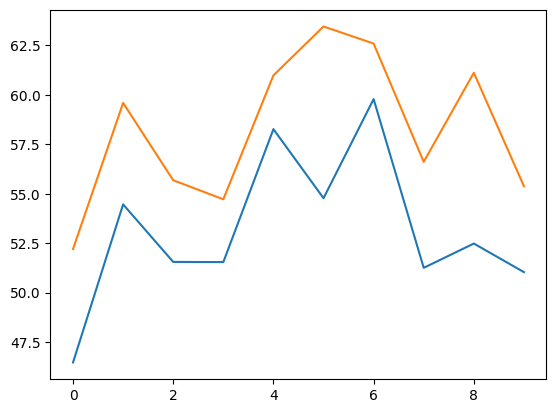

In [438]:
#plt.plot(range(count),alg_results)
#plt.plot(range(count),alg_results_2)
plt.plot(range(count),alg_results_3)
plt.plot(range(count),gur_results)

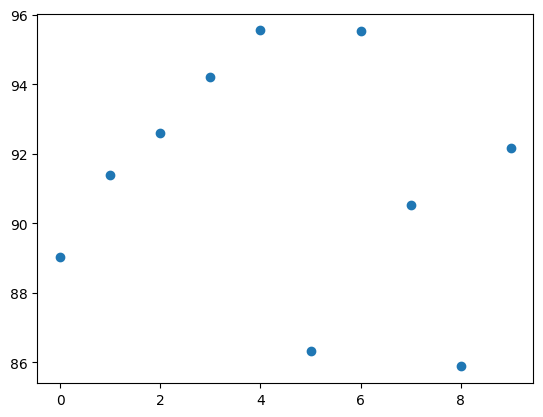

In [439]:
plt.scatter(range(count),alg_results_3/gur_results*100)

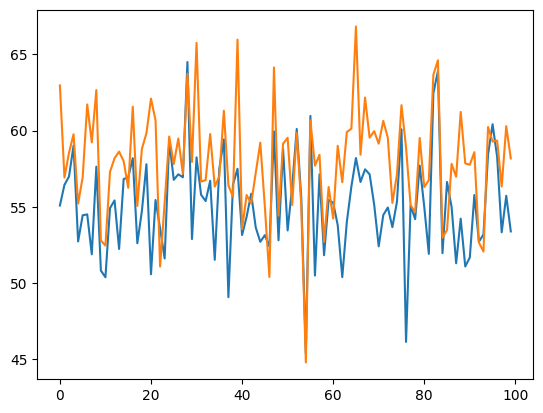

In [54]:
plt.plot(range(count),alg_results)
plt.plot(range(count),gur_results)

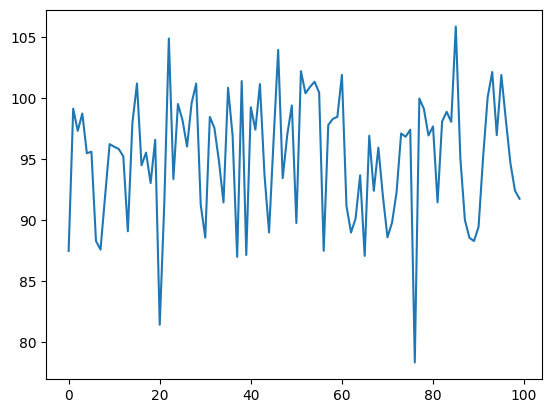

In [55]:
plt.plot(range(count),alg_results/gur_results*100)

In [343]:
for i in range(count):
    clients_list,time_slot,answer,groups,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util=problem_maker(num_of_clients,num_of_dims,time_length,gr_util,gr_time)
    inputs,labels=data_preprocess(groups,num_of_clients,num_of_dims,time_length,total_demand,min_av_max_caps,av_cap_bytime,min_util,av_util)
    inputs=torch.from_numpy(np.float32(inputs[None,:])).to(device)
    y_pred=knapsack_model(inputs).squeeze()
    sel_it,util=selection_algorithm(clients_list,time_slot,groups,total_demand,y_pred)
    alg_results[i]=util
    gur_results[i]=clients_list[answer==1][:,-2].sum()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4512 nonzeros
Model fingerprint: 0xe579642d
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 32377.975318
Presolve removed 160 rows and 16 columns
Presolve time: 0.00s
Presolved: 20 rows, 84 columns, 637 nonzeros
Variable types: 0 continuous, 84 integer (84 binary)
Found heuristic solution: objective 33197.639250

Root relaxation: objective 3.460485e+04, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

     0     0 40576.0315    0    9 40527.3083 40576.0315  0.12%     -    0s
     0     0 40570.6069    0    9 40527.3083 40570.6069  0.11%     -    0s
     0     0 40570.4000    0   10 40527.3083 40570.4000  0.11%     -    0s
     0     0 40570.4000    0   12 40527.3083 40570.4000  0.11%     -    0s

Cutting planes:
  Cover: 2
  MIR: 8
  StrongCG: 2

Explored 1 nodes (79 simplex iterations) in 0.07 seconds (0.02 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: 40527.3 40484.3 40150.8 ... 37534.1

Optimal solution found (tolerance 1.00e-04)
Best objective 4.052730828542e+04, best bound 4.053064155067e+04, gap 0.0082%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5748 nonzeros
Model fingerprint: 0xbc5fc738
Variable types: 0 continuous, 100 

     0     0 37478.6297    0    7 37315.0519 37478.6297  0.44%     -    0s
     0     0 37467.4083    0   10 37315.0519 37467.4083  0.41%     -    0s
     0     0 37467.4083    0   10 37315.0519 37467.4083  0.41%     -    0s
     0     0 37467.4083    0    9 37315.0519 37467.4083  0.41%     -    0s
     0     0 37467.4083    0   10 37315.0519 37467.4083  0.41%     -    0s
     0     0 37458.0133    0   11 37315.0519 37458.0133  0.38%     -    0s
     0     0 37458.0133    0   10 37315.0519 37458.0133  0.38%     -    0s
     0     0 37458.0133    0   11 37315.0519 37458.0133  0.38%     -    0s
     0     0 37458.0133    0   12 37315.0519 37458.0133  0.38%     -    0s
     0     0 37458.0133    0   12 37315.0519 37458.0133  0.38%     -    0s
H    0     0                    37326.031732 37458.0133  0.35%     -    0s
     0     0 37447.7836    0   11 37326.0317 37447.7836  0.33%     -    0s
     0     0 37446.0682    0   12 37326.0317 37446.0682  0.32%     -    0s
     0     0 37446.0682  


Cutting planes:
  Cover: 4
  MIR: 15
  StrongCG: 4

Explored 46 nodes (577 simplex iterations) in 0.20 seconds (0.04 work units)
Thread count was 16 (of 16 available processors)

Solution count 9: 39343 39312 39256 ... 31633.5

Optimal solution found (tolerance 1.00e-04)
Best objective 3.934303317537e+04, best bound 3.934430200287e+04, gap 0.0032%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4908 nonzeros
Model fingerprint: 0xbef12531
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 29021.511739
Presolve removed 135 rows and 9 columns
Presolve time: 0.00s
Presolved: 4

     0     0 45479.4792    0   10 45411.8706 45479.4792  0.15%     -    0s
     0     0 45479.3423    0   10 45411.8706 45479.3423  0.15%     -    0s
     0     0 45479.2076    0   10 45411.8706 45479.2076  0.15%     -    0s
     0     0 45479.0518    0   10 45411.8706 45479.0518  0.15%     -    0s
     0     0 45471.9267    0    8 45411.8706 45471.9267  0.13%     -    0s
     0     0 45471.4323    0    8 45411.8706 45471.4323  0.13%     -    0s
     0     2 45471.4323    0    8 45411.8706 45471.4323  0.13%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 9
  MIR: 10
  StrongCG: 12
  RLT: 1

Explored 496 nodes (2147 simplex iterations) in 0.13 seconds (0.05 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: 45411.9 45290.4 44707.2 ... 40381.5

Optimal solution found (tolerance 1.00e-04)
Best objective 4.541187058530e+04, best bound 4.541187058530e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Ra

     0     0 33319.6422    0   12 33156.5891 33319.6422  0.49%     -    0s
     0     0 33310.9449    0   11 33156.5891 33310.9449  0.47%     -    0s
     0     0 33294.5075    0   13 33156.5891 33294.5075  0.42%     -    0s
     0     0 33294.2217    0   12 33156.5891 33294.2217  0.42%     -    0s
     0     0 33285.3749    0   12 33156.5891 33285.3749  0.39%     -    0s
     0     0 33285.2468    0   11 33156.5891 33285.2468  0.39%     -    0s
     0     0 33284.8819    0   10 33156.5891 33284.8819  0.39%     -    0s
     0     0 33283.7993    0   14 33156.5891 33283.7993  0.38%     -    0s
     0     0 33283.6775    0   14 33156.5891 33283.6775  0.38%     -    0s
     0     0 33282.0948    0   15 33156.5891 33282.0948  0.38%     -    0s
     0     0 33281.4523    0   14 33156.5891 33281.4523  0.38%     -    0s
     0     0 33281.1776    0   14 33156.5891 33281.1776  0.38%     -    0s
     0     0 33281.1363    0   14 33156.5891 33281.1363  0.38%     -    0s
     0     0 33273.6614  

     0     0 43437.1115    0    5 43239.3663 43437.1115  0.46%     -    0s
     0     0 43436.0952    0    6 43239.3663 43436.0952  0.45%     -    0s
     0     0 43436.0807    0    6 43239.3663 43436.0807  0.45%     -    0s
     0     0 43402.7179    0    6 43239.3663 43402.7179  0.38%     -    0s
H    0     0                    43269.425960 43402.7179  0.31%     -    0s
     0     0 43400.8912    0    9 43269.4260 43400.8912  0.30%     -    0s
     0     0 43400.7030    0    6 43269.4260 43400.7030  0.30%     -    0s
     0     0 43400.6321    0    7 43269.4260 43400.6321  0.30%     -    0s
     0     0 43387.6688    0   11 43269.4260 43387.6688  0.27%     -    0s
     0     0 43379.3975    0   12 43269.4260 43379.3975  0.25%     -    0s
     0     0 43378.1633    0   13 43269.4260 43378.1633  0.25%     -    0s
     0     0 43366.4114    0   11 43269.4260 43366.4114  0.22%     -    0s
     0     0 43362.1417    0   12 43269.4260 43362.1417  0.21%     -    0s
     0     0 43346.6840  

     0     0 26728.4189    0    6 26598.1325 26728.4189  0.49%     -    0s
H    0     0                    26610.696603 26728.4189  0.44%     -    0s
H    0     0                    26619.682355 26728.4189  0.41%     -    0s
     0     0 26715.6114    0    7 26619.6824 26715.6114  0.36%     -    0s
     0     0 26715.6114    0    9 26619.6824 26715.6114  0.36%     -    0s
     0     0 26711.4463    0    7 26619.6824 26711.4463  0.34%     -    0s
H    0     0                    26622.113705 26711.4463  0.34%     -    0s
H    0     0                    26639.508377 26711.4463  0.27%     -    0s
     0     0 26709.9057    0    8 26639.5084 26709.9057  0.26%     -    0s
     0     0 26709.6672    0    8 26639.5084 26709.6672  0.26%     -    0s
H    0     0                    26640.914373 26709.6672  0.26%     -    0s
     0     0 26708.8013    0    8 26640.9144 26708.8013  0.25%     -    0s
     0     0 26705.5709    0    9 26640.9144 26705.5709  0.24%     -    0s
     0     0 26705.4789  

     0     2 31122.1174    0   10 31047.7467 31122.1174  0.24%     -    0s

Cutting planes:
  Gomory: 6
  Cover: 11
  MIR: 10
  StrongCG: 8

Explored 688 nodes (3181 simplex iterations) in 0.16 seconds (0.04 work units)
Thread count was 16 (of 16 available processors)

Solution count 9: 31047.7 31026.3 30928.8 ... 29195.4

Optimal solution found (tolerance 1.00e-04)
Best objective 3.104774673668e+04, best bound 3.104774673668e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5808 nonzeros
Model fingerprint: 0x02931272
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: 

  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 30725.010928
Presolve removed 134 rows and 12 columns
Presolve time: 0.00s
Presolved: 46 rows, 88 columns, 1665 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 32488.357757

Root relaxation: objective 3.395389e+04, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 33953.8930    0    6 32488.3578 33953.8930  4.51%     -    0s
H    0     0                    33520.966409 33953.8930  1.29%     -    0s
H    0     0                    33548.910778 33953.8930  1.21%     -    0s
H    0     0                    33818.807860 33953.8930  0.40%     -    0s
H    0     0                    33848.422516 33942.6887  0.28%     -    0s
     0     0 33939.9532    0    7 33848.4225 33939.9532  0.27%     -    0s
     0     0 3393


Optimize a model with 180 rows, 100 columns and 5172 nonzeros
Model fingerprint: 0x89f0d342
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 36794.596515
Presolve removed 134 rows and 8 columns
Presolve time: 0.00s
Presolved: 46 rows, 92 columns, 1752 nonzeros
Variable types: 0 continuous, 92 integer (92 binary)
Found heuristic solution: objective 38453.183596

Root relaxation: objective 4.008986e+04, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 40089.8587    0    4 38453.1836 40089.8587  4.26%     -    0s
H    0     0                    39681.347728 40089.8587  1.03%     -    0s
H    0     0                    39836.483320

Model fingerprint: 0x5d58a06e
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 36625.788946
Presolve removed 157 rows and 11 columns
Presolve time: 0.00s
Presolved: 23 rows, 89 columns, 777 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
Found heuristic solution: objective 39175.446237

Root relaxation: objective 4.164567e+04, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 41645.6674    0    6 39175.4462 41645.6674  6.31%     -    0s
H    0     0                    40890.991866 41645.6674  1.85%     -    0s
H    0     0                    41148.263375 41645.6674  1.21%     -    0s
H    0     0                    

Presolve time: 0.00s
Presolved: 19 rows, 89 columns, 631 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
Found heuristic solution: objective 38041.856043

Root relaxation: objective 4.014393e+04, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 40143.9345    0    6 38041.8560 40143.9345  5.53%     -    0s
H    0     0                    39466.815294 40143.9345  1.72%     -    0s
H    0     0                    39855.679559 40143.9345  0.72%     -    0s
H    0     0                    39969.886053 40143.9345  0.44%     -    0s
     0     0 40124.3840    0    7 39969.8861 40124.3840  0.39%     -    0s
     0     0 40124.3840    0    6 39969.8861 40124.3840  0.39%     -    0s
     0     0 40116.7875    0    8 39969.8861 40116.7875  0.37%     -    0s
     0     0 40096.8583    0    8 39969.8861 40096.8583  0.32%     

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 42629.8154    0    5 39818.9641 42629.8154  7.06%     -    0s
H    0     0                    41656.145280 42629.8154  2.34%     -    0s
H    0     0                    42057.616435 42629.8154  1.36%     -    0s
H    0     0                    42423.702375 42629.8154  0.49%     -    0s
     0     0 42609.3826    0    7 42423.7024 42609.3826  0.44%     -    0s
     0     0 42609.3826    0    5 42423.7024 42609.3826  0.44%     -    0s
     0     0 42609.3826    0    7 42423.7024 42609.3826  0.44%     -    0s
H    0     0                    42459.920321 42609.3826  0.35%     -    0s
     0     0 42582.1263    0    8 42459.9203 42582.1263  0.29%     -    0s
     0     0 42579.0872    0    8 42459.9203 42579.0872  0.28%     -    0s
     0     0 42564.6441    0    7 42459.9203 42564.6441  0.25%     -    0s
     0     0 42558.6705    0   10 42459.9203 42558.6705  0.23%     -    0s
     0     0 42556.653

H    0     0                    41009.343134 41246.1150  0.58%     -    0s
     0     0 41197.3887    0    6 41009.3431 41197.3887  0.46%     -    0s
     0     0 41197.3887    0    5 41009.3431 41197.3887  0.46%     -    0s
H    0     0                    41011.064718 41197.3887  0.45%     -    0s
     0     0 41197.3887    0    6 41011.0647 41197.3887  0.45%     -    0s
     0     0 41187.5724    0    6 41011.0647 41187.5724  0.43%     -    0s
     0     0 41187.5724    0    8 41011.0647 41187.5724  0.43%     -    0s
     0     0 41187.5724    0    9 41011.0647 41187.5724  0.43%     -    0s
     0     0 41179.0184    0   10 41011.0647 41179.0184  0.41%     -    0s
     0     0 41174.3979    0   10 41011.0647 41174.3979  0.40%     -    0s
     0     0 41170.1349    0   11 41011.0647 41170.1349  0.39%     -    0s
     0     0 41169.0204    0   10 41011.0647 41169.0204  0.39%     -    0s
     0     0 41168.6311    0   11 41011.0647 41168.6311  0.38%     -    0s
     0     0 41163.5651  

     0     0 41066.9952    0    9 40785.8086 41066.9952  0.69%     -    0s
H    0     0                    40799.118068 41066.9952  0.66%     -    0s
H    0     0                    40842.968239 41066.9952  0.55%     -    0s
H    0     0                    40873.175896 41066.9952  0.47%     -    0s
     0     0 41008.9092    0    8 40873.1759 41008.9092  0.33%     -    0s
     0     0 41005.7476    0    8 40873.1759 41005.7476  0.32%     -    0s
     0     0 41002.2923    0    9 40873.1759 41002.2923  0.32%     -    0s
     0     0 40999.6269    0    9 40873.1759 40999.6269  0.31%     -    0s
     0     0 40999.2813    0   10 40873.1759 40999.2813  0.31%     -    0s
     0     0 40999.2701    0    8 40873.1759 40999.2701  0.31%     -    0s
     0     0 40998.2474    0    8 40873.1759 40998.2474  0.31%     -    0s
     0     0 40998.0431    0    8 40873.1759 40998.0431  0.31%     -    0s
     0     0 40994.4398    0    9 40873.1759 40994.4398  0.30%     -    0s
     0     0 40992.1286  

Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 31524.778280
Presolve removed 163 rows and 14 columns
Presolve time: 0.00s
Presolved: 17 rows, 86 columns, 539 nonzeros
Variable types: 0 continuous, 86 integer (86 binary)
Found heuristic solution: objective 32408.872940

Root relaxation: objective 3.433124e+04, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 34331.2402    0    4 32408.8729 34331.2402  5.93%     -    0s
H    0     0                    33474.753074 34331.2402  2.56%     -    0s
H    0     0                    33886.847484 34331.2402  1.31%     -    0s
H    0     0                    34012.172100 34331.2402  0.94%     -    0s
H    0     0                    34021.80571

  StrongCG: 2

Explored 1 nodes (109 simplex iterations) in 0.10 seconds (0.02 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: 28304.7 28192.1 28154 ... 24769.3

Optimal solution found (tolerance 1.00e-04)
Best objective 2.830469082765e+04, best bound 2.830705903468e+04, gap 0.0084%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4830 nonzeros
Model fingerprint: 0xdf221e50
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 31179.934851
Presolve removed 156 rows and 8 columns
Presolve time: 0.00s
Presolved: 24 rows, 92 columns, 871 nonzeros
Va


Optimal solution found (tolerance 1.00e-04)
Best objective 3.837367212160e+04, best bound 3.837679598838e+04, gap 0.0081%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4782 nonzeros
Model fingerprint: 0xf50d32bb
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 28515.711196
Presolve removed 163 rows and 10 columns
Presolve time: 0.00s
Presolved: 17 rows, 90 columns, 547 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)
Found heuristic solution: objective 32252.163893

Root relaxation: objective 3.428931e+04, 11 iterations, 0.00 seconds (0.00 work units)

   

     0     0 29467.5374    0   15 29393.6155 29467.5374  0.25%     -    0s
     0     0 29467.4586    0   15 29393.6155 29467.4586  0.25%     -    0s
     0     0 29467.4339    0   16 29393.6155 29467.4339  0.25%     -    0s
     0     0 29465.7557    0   16 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0    4 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0    5 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0    8 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0    9 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0   13 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0   14 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0   15 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7557    0   16 29393.6155 29465.7557  0.25%     -    0s
     0     0 29465.7196    0   17 29393.6155 29465.7196  0.25%     -    0s
     0     0 29465.2269  


Optimal solution found (tolerance 1.00e-04)
Best objective 3.738884078204e+04, best bound 3.739080087362e+04, gap 0.0052%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4320 nonzeros
Model fingerprint: 0x02d7c919
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 30904.859077
Presolve removed 168 rows and 24 columns
Presolve time: 0.00s
Presolved: 12 rows, 76 columns, 378 nonzeros
Variable types: 0 continuous, 76 integer (76 binary)
Found heuristic solution: objective 32952.629658

Root relaxation: objective 3.439454e+04, 12 iterations, 0.00 seconds (0.00 work units)

   

     0     0 48140.9385    0   15 48070.3572 48140.9385  0.15%     -    0s
     0     0 48137.0394    0   15 48070.3572 48137.0394  0.14%     -    0s
     0     0 48136.9646    0   15 48070.3572 48136.9646  0.14%     -    0s
     0     0 48132.1169    0   14 48070.3572 48132.1169  0.13%     -    0s
     0     0 48131.9577    0    4 48070.3572 48131.9577  0.13%     -    0s
     0     0 48131.9577    0    8 48070.3572 48131.9577  0.13%     -    0s
     0     0 48131.9577    0   11 48070.3572 48131.9577  0.13%     -    0s
     0     0 48131.9577    0   12 48070.3572 48131.9577  0.13%     -    0s
     0     0 48131.9577    0   13 48070.3572 48131.9577  0.13%     -    0s
     0     0 48131.9577    0   14 48070.3572 48131.9577  0.13%     -    0s
     0     0 48131.9577    0   14 48070.3572 48131.9577  0.13%     -    0s
     0     2 48131.9577    0   14 48070.3572 48131.9577  0.13%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 10
  MIR: 10
  StrongCG: 6

Explored 355 nodes (1847 simplex i

H    0     0                    30673.242132 30926.2483  0.82%     -    0s
H    0     0                    30710.990432 30926.2483  0.70%     -    0s
     0     0 30888.7314    0    6 30710.9904 30888.7314  0.58%     -    0s
     0     0 30888.7314    0    6 30710.9904 30888.7314  0.58%     -    0s
H    0     0                    30741.849388 30888.7314  0.48%     -    0s
     0     0 30888.7314    0    7 30741.8494 30888.7314  0.48%     -    0s
H    0     0                    30769.419609 30888.7314  0.39%     -    0s
     0     0 30882.5221    0    8 30769.4196 30882.5221  0.37%     -    0s
     0     0 30882.5221    0    9 30769.4196 30882.5221  0.37%     -    0s
     0     0 30882.5221    0    9 30769.4196 30882.5221  0.37%     -    0s
     0     0 30882.5221    0   10 30769.4196 30882.5221  0.37%     -    0s
     0     0 30873.9663    0   10 30769.4196 30873.9663  0.34%     -    0s
     0     0 30864.2172    0    9 30769.4196 30864.2172  0.31%     -    0s
     0     0 30864.2172  

Thread count was 16 (of 16 available processors)

Solution count 6: 36811.9 36797.7 36782.8 ... 31717.9

Optimal solution found (tolerance 1.00e-04)
Best objective 3.681188048624e+04, best bound 3.681188048624e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4548 nonzeros
Model fingerprint: 0xaeeb553b
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 32721.277979
Presolve removed 164 rows and 19 columns
Presolve time: 0.00s
Presolved: 16 rows, 81 columns, 534 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)
Found heuristic solution: objective 3

     0     0 29206.7967    0   10 29117.9987 29206.7967  0.30%     -    0s
     0     0 29202.7151    0   11 29117.9987 29202.7151  0.29%     -    0s
     0     0 29197.8121    0   12 29117.9987 29197.8121  0.27%     -    0s
     0     0 29197.0735    0   12 29117.9987 29197.0735  0.27%     -    0s
     0     0 29197.0043    0   13 29117.9987 29197.0043  0.27%     -    0s
     0     0 29193.2898    0   12 29117.9987 29193.2898  0.26%     -    0s
     0     0 29190.3066    0   12 29117.9987 29190.3066  0.25%     -    0s
     0     0 29189.9014    0   13 29117.9987 29189.9014  0.25%     -    0s
     0     0 29189.3454    0   14 29117.9987 29189.3454  0.25%     -    0s
     0     0 29188.5335    0   15 29117.9987 29188.5335  0.24%     -    0s
     0     0 29188.0778    0   14 29117.9987 29188.0778  0.24%     -    0s
     0     0 29185.6948    0   14 29117.9987 29185.6948  0.23%     -    0s
     0     2 29185.3510    0   14 29117.9987 29185.3510  0.23%     -    0s

Cutting planes:
  Cover:

     0     0 33669.9235    0   17 33515.2797 33669.9235  0.46%     -    0s
     0     0 33668.5113    0   19 33515.2797 33668.5113  0.46%     -    0s
     0     0 33667.1038    0   18 33515.2797 33667.1038  0.45%     -    0s
     0     0 33666.8705    0   18 33515.2797 33666.8705  0.45%     -    0s
     0     0 33661.1761    0   19 33515.2797 33661.1761  0.44%     -    0s
     0     0 33660.8041    0   19 33515.2797 33660.8041  0.43%     -    0s
     0     0 33660.6699    0   20 33515.2797 33660.6699  0.43%     -    0s
     0     0 33660.5675    0   20 33515.2797 33660.5675  0.43%     -    0s
     0     0 33658.5221    0   19 33515.2797 33658.5221  0.43%     -    0s
     0     0 33658.1230    0   20 33515.2797 33658.1230  0.43%     -    0s
     0     0 33655.2240    0   16 33515.2797 33655.2240  0.42%     -    0s
     0     0 33654.7531    0   21 33515.2797 33654.7531  0.42%     -    0s
     0     0 33654.4038    0   22 33515.2797 33654.4038  0.42%     -    0s
     0     0 33654.3440  

H    0     0                    40939.399589 41800.6327  2.10%     -    0s
H    0     0                    41315.970807 41800.6327  1.17%     -    0s
H    0     0                    41454.010241 41800.6327  0.84%     -    0s
H    0     0                    41578.242174 41800.6327  0.53%     -    0s
     0     0 41748.3336    0    9 41578.2422 41748.3336  0.41%     -    0s
     0     0 41748.3336    0    7 41578.2422 41748.3336  0.41%     -    0s
     0     0 41744.0650    0    9 41578.2422 41744.0650  0.40%     -    0s
     0     0 41727.4730    0    7 41578.2422 41727.4730  0.36%     -    0s
     0     0 41717.7325    0    9 41578.2422 41717.7325  0.34%     -    0s
H    0     0                    41589.198111 41717.7325  0.31%     -    0s
     0     0 41708.4448    0    9 41589.1981 41708.4448  0.29%     -    0s
     0     0 41707.9329    0    9 41589.1981 41707.9329  0.29%     -    0s
     0     0 41707.1929    0   11 41589.1981 41707.1929  0.28%     -    0s
     0     0 41696.0985  

H  887   144                    43835.783231 43940.2866  0.24%   4.9    0s

Cutting planes:
  Cover: 32
  MIR: 19
  StrongCG: 7
  Inf proof: 2

Explored 1262 nodes (6405 simplex iterations) in 0.29 seconds (0.10 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 43835.8 43830.5 43828.2 ... 43591.2

Optimal solution found (tolerance 1.00e-04)
Best objective 4.383578323150e+04, best bound 4.383578323150e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5298 nonzeros
Model fingerprint: 0x4fb64fe4
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solut


Cutting planes:
  Gomory: 1
  Lift-and-project: 1
  Cover: 9
  MIR: 15
  StrongCG: 4

Explored 420 nodes (2133 simplex iterations) in 0.26 seconds (0.10 work units)
Thread count was 16 (of 16 available processors)

Solution count 6: 32892.9 32854.4 32762.4 ... 29860.7

Optimal solution found (tolerance 1.00e-04)
Best objective 3.289292262669e+04, best bound 3.289292262669e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4350 nonzeros
Model fingerprint: 0x04fde614
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 25450.449319
Presolve removed 160 rows and 1

     0     0 24517.0672    0   12 24395.5549 24517.0672  0.50%     -    0s
     0     0 24517.0672    0   12 24395.5549 24517.0672  0.50%     -    0s
     0     0 24512.0515    0   10 24395.5549 24512.0515  0.48%     -    0s
     0     0 24512.0476    0    4 24395.5549 24512.0476  0.48%     -    0s
     0     0 24512.0476    0    6 24395.5549 24512.0476  0.48%     -    0s
     0     0 24512.0476    0    6 24395.5549 24512.0476  0.48%     -    0s
     0     0 24512.0476    0    8 24395.5549 24512.0476  0.48%     -    0s
     0     0 24512.0476    0   10 24395.5549 24512.0476  0.48%     -    0s
     0     0 24512.0476    0   10 24395.5549 24512.0476  0.48%     -    0s
     0     0 24511.9670    0    7 24395.5549 24511.9670  0.48%     -    0s
     0     0 24511.9670    0    8 24395.5549 24511.9670  0.48%     -    0s
     0     0 24511.9670    0    9 24395.5549 24511.9670  0.48%     -    0s
     0     0 24511.6437    0   10 24395.5549 24511.6437  0.48%     -    0s
     0     0 24511.6423  

H    0     0                    41945.607244 42441.5767  1.18%     -    0s
H    0     0                    42050.596137 42441.5767  0.93%     -    0s
H    0     0                    42126.711259 42441.5767  0.75%     -    0s
H    0     0                    42133.476662 42441.5767  0.73%     -    0s
     0     0 42394.8944    0   12 42133.4767 42394.8944  0.62%     -    0s
     0     0 42394.8944    0    8 42133.4767 42394.8944  0.62%     -    0s
     0     0 42394.8944    0   10 42133.4767 42394.8944  0.62%     -    0s
H    0     0                    42209.591784 42394.8944  0.44%     -    0s
     0     0 42386.1519    0   13 42209.5918 42386.1519  0.42%     -    0s
     0     0 42386.0468    0    9 42209.5918 42386.0468  0.42%     -    0s
     0     0 42385.5101    0   10 42209.5918 42385.5101  0.42%     -    0s
     0     0 42384.0592    0   11 42209.5918 42384.0592  0.41%     -    0s
     0     0 42370.8972    0   11 42209.5918 42370.8972  0.38%     -    0s
     0     0 42357.3391  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 41018.0238    0    6 38478.1153 41018.0238  6.60%     -    0s
H    0     0                    40404.222955 41018.0238  1.52%     -    0s
H    0     0                    40530.497485 41018.0238  1.20%     -    0s
H    0     0                    40766.394279 41018.0238  0.62%     -    0s
H    0     0                    40798.494626 41018.0238  0.54%     -    0s
H    0     0                    40821.299494 41018.0238  0.48%     -    0s
     0     0 40989.6860    0    9 40821.2995 40989.6860  0.41%     -    0s
     0     0 40989.6860    0    6 40821.2995 40989.6860  0.41%     -    0s
     0     0 40989.6860    0    9 40821.2995 40989.6860  0.41%     -    0s
     0     0 40980.8184    0    7 40821.2995 40980.8184  0.39%     -    0s
     0     0 40979.8237    0    7 40821.2995 40979.8237  0.39%     -    0s
     0     0 40979.4247    0    8 40821.2995 40979.4247  0.39%     -    0s
     0     0 40972.102

Found heuristic solution: objective 34343.992102

Root relaxation: objective 3.573651e+04, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 35736.5067    0    5 34343.9921 35736.5067  4.05%     -    0s
H    0     0                    35137.269637 35736.5067  1.71%     -    0s
H    0     0                    35408.770188 35736.5067  0.93%     -    0s
H    0     0                    35449.416700 35736.5067  0.81%     -    0s
H    0     0                    35475.006918 35671.0820  0.55%     -    0s
     0     0 35671.0820    0    6 35475.0069 35671.0820  0.55%     -    0s
     0     0 35671.0820    0    5 35475.0069 35671.0820  0.55%     -    0s
     0     0 35662.6483    0    8 35475.0069 35662.6483  0.53%     -    0s
H    0     0                    35516.947587 35662.6483  0.41%     -    0s
     0     0 35655.8121    0    9 35

     0     0 38890.7395    0   21 38832.5415 38890.7395  0.15%     -    0s
     0     0 38867.9987    0   18 38832.5415 38867.9987  0.09%     -    0s
     0     0 38867.9987    0   18 38832.5415 38867.9987  0.09%     -    0s
     0     2 38867.9987    0   18 38832.5415 38867.9987  0.09%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 10
  MIR: 15
  StrongCG: 12

Explored 77 nodes (690 simplex iterations) in 0.17 seconds (0.05 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: 38832.5 38754.9 38564.3 ... 33750.3

Optimal solution found (tolerance 1.00e-04)
Best objective 3.883254146746e+04, best bound 3.883254146746e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 5058 nonzeros
Model fingerprint: 0xdc815949
Variable types: 0

     0     0 33416.4119    0   11 33303.9066 33416.4119  0.34%     -    0s
     0     0 33414.1074    0   10 33303.9066 33414.1074  0.33%     -    0s
     0     0 33410.6780    0   10 33303.9066 33410.6780  0.32%     -    0s
     0     0 33408.8100    0   10 33303.9066 33408.8100  0.31%     -    0s
     0     0 33408.1515    0   11 33303.9066 33408.1515  0.31%     -    0s
     0     0 33402.3927    0   10 33303.9066 33402.3927  0.30%     -    0s
     0     0 33392.6958    0   11 33303.9066 33392.6958  0.27%     -    0s
     0     0 33391.4840    0   11 33303.9066 33391.4840  0.26%     -    0s
     0     0 33391.4695    0   10 33303.9066 33391.4695  0.26%     -    0s
     0     0 33391.4695    0   12 33303.9066 33391.4695  0.26%     -    0s
     0     0 33391.4695    0   14 33303.9066 33391.4695  0.26%     -    0s
     0     0 33389.3339    0   13 33303.9066 33389.3339  0.26%     -    0s
     0     0 33388.1244    0   12 33303.9066 33388.1244  0.25%     -    0s
     0     0 33387.9110  

     0     0 27997.9827    0   11 27900.3937 27997.9827  0.35%     -    0s
     0     0 27997.9827    0   11 27900.3937 27997.9827  0.35%     -    0s
     0     0 27997.9827    0   12 27900.3937 27997.9827  0.35%     -    0s
     0     0 27997.9827    0   12 27900.3937 27997.9827  0.35%     -    0s
     0     0 27993.3872    0   10 27900.3937 27993.3872  0.33%     -    0s
     0     2 27993.3785    0   10 27900.3937 27993.3785  0.33%     -    0s
H 2616   291                    27908.198683 27952.3581  0.16%   4.4    0s

Cutting planes:
  Gomory: 2
  Cover: 55
  MIR: 18
  StrongCG: 8
  Inf proof: 2

Explored 3490 nodes (15923 simplex iterations) in 0.22 seconds (0.12 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: 27908.2 27900.4 27842.9 ... 25199.6

Optimal solution found (tolerance 1.00e-04)
Best objective 2.790819868323e+04, best bound 2.790819868323e+04, gap 0.0000%
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 4800H

     0     0 35355.7139    0   21 35268.0349 35355.7139  0.25%     -    0s
     0     0 35355.6402    0   20 35268.0349 35355.6402  0.25%     -    0s
     0     0 35353.6616    0   21 35268.0349 35353.6616  0.24%     -    0s
     0     0 35351.8948    0   20 35268.0349 35351.8948  0.24%     -    0s
     0     0 35351.2223    0   20 35268.0349 35351.2223  0.24%     -    0s
     0     0 35351.1043    0   21 35268.0349 35351.1043  0.24%     -    0s
     0     0 35350.5087    0   22 35268.0349 35350.5087  0.23%     -    0s
     0     0 35350.3734    0   22 35268.0349 35350.3734  0.23%     -    0s
     0     0 35349.6558    0   21 35268.0349 35349.6558  0.23%     -    0s
     0     0 35349.3818    0   21 35268.0349 35349.3818  0.23%     -    0s
     0     0 35349.2972    0   21 35268.0349 35349.2972  0.23%     -    0s
     0     0 35349.2502    0   22 35268.0349 35349.2502  0.23%     -    0s
     0     0 35346.6680    0   22 35268.0349 35346.6680  0.22%     -    0s
     0     0 35345.3509  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 34944.8622    0    6 33456.7440 34944.8622  4.45%     -    0s
H    0     0                    34565.274155 34944.8622  1.10%     -    0s
H    0     0                    34755.198935 34944.8622  0.55%     -    0s
     0     0 34908.9076    0    9 34755.1989 34908.9076  0.44%     -    0s
     0     0 34908.9076    0    6 34755.1989 34908.9076  0.44%     -    0s
     0     0 34902.1857    0    8 34755.1989 34902.1857  0.42%     -    0s
     0     0 34874.8489    0   10 34755.1989 34874.8489  0.34%     -    0s
     0     0 34870.3058    0   11 34755.1989 34870.3058  0.33%     -    0s
     0     0 34867.0240    0   11 34755.1989 34867.0240  0.32%     -    0s
     0     0 34864.1029    0   11 34755.1989 34864.1029  0.31%     -    0s
     0     0 34862.8741    0   11 34755.1989 34862.8741  0.31%     -    0s
     0     0 34862.8741


CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 180 rows, 100 columns and 4890 nonzeros
Model fingerprint: 0xde235db0
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [3e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+02, 2e+03]
Found heuristic solution: objective 34134.972425
Presolve removed 144 rows and 29 columns
Presolve time: 0.00s
Presolved: 36 rows, 71 columns, 1303 nonzeros
Variable types: 0 continuous, 71 integer (71 binary)
Found heuristic solution: objective 35736.545757

Root relaxation: objective 3.698182e+04, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 36981.8162    0   

     0     0 36865.1759    0    6 36832.9935 36865.1759  0.09%     -    0s
     0     0 36865.1759    0    7 36832.9935 36865.1759  0.09%     -    0s
     0     0 36865.1759    0    9 36832.9935 36865.1759  0.09%     -    0s
     0     0 36865.1759    0    7 36832.9935 36865.1759  0.09%     -    0s
     0     0 36863.4839    0   10 36832.9935 36863.4839  0.08%     -    0s
     0     0 36863.4839    0   10 36832.9935 36863.4839  0.08%     -    0s
     0     0 36863.4839    0   10 36832.9935 36863.4839  0.08%     -    0s
     0     0 36863.4839    0   10 36832.9935 36863.4839  0.08%     -    0s
     0     0 36863.1897    0   10 36832.9935 36863.1897  0.08%     -    0s
     0     0 36855.6632    0   11 36832.9935 36855.6632  0.06%     -    0s
     0     0 36855.6632    0   11 36832.9935 36855.6632  0.06%     -    0s
     0     2 36855.6632    0   11 36832.9935 36855.6632  0.06%     -    0s

Cutting planes:
  Cover: 9
  MIR: 6
  StrongCG: 3

Explored 122 nodes (477 simplex iterations) in 0

H    0     0                    38631.933986 38978.2905  0.90%     -    0s
H    0     0                    38721.883262 38978.2905  0.66%     -    0s
     0     0 38951.7731    0    8 38721.8833 38951.7731  0.59%     -    0s
     0     0 38951.7731    0    6 38721.8833 38951.7731  0.59%     -    0s
     0     0 38946.3206    0    8 38721.8833 38946.3206  0.58%     -    0s
     0     0 38891.1562    0    8 38721.8833 38891.1562  0.44%     -    0s
     0     0 38891.1562    0    9 38721.8833 38891.1562  0.44%     -    0s
     0     0 38891.1562    0    8 38721.8833 38891.1562  0.44%     -    0s
     0     0 38891.1562    0    9 38721.8833 38891.1562  0.44%     -    0s
     0     0 38885.7509    0    9 38721.8833 38885.7509  0.42%     -    0s
H    0     0                    38726.703570 38885.7509  0.41%     -    0s
     0     0 38871.6984    0   10 38726.7036 38871.6984  0.37%     -    0s
     0     0 38871.6984    0   13 38726.7036 38871.6984  0.37%     -    0s
     0     0 38871.6984  

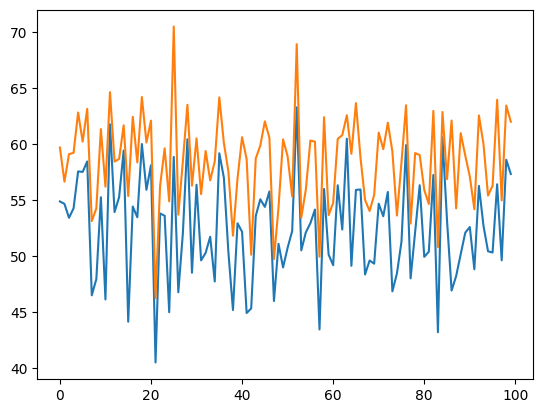

In [63]:
#plt.plot(range(count),alg_results)
#plt.plot(range(count),alg_results_2)
plt.plot(range(count),alg_results_3)
plt.plot(range(count),gur_results)

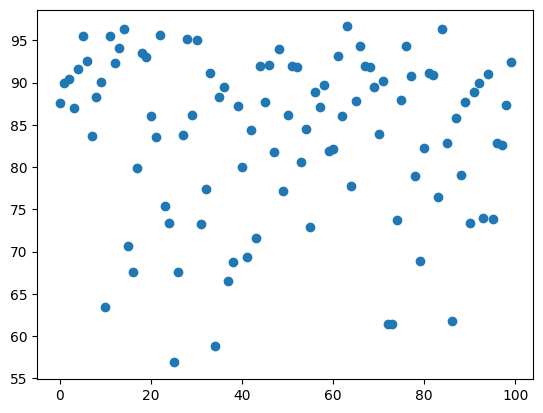

In [57]:
plt.scatter(range(count),alg_results/gur_results*100)

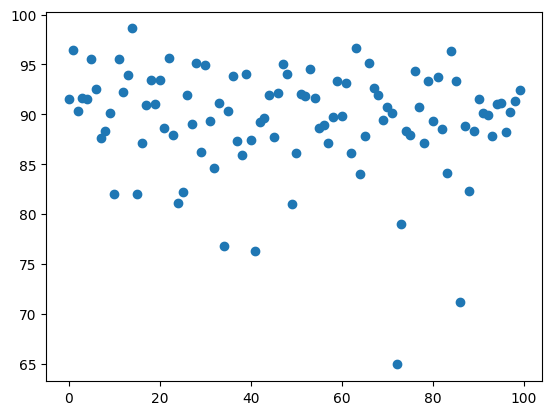

In [58]:
plt.scatter(range(count),alg_results_2/gur_results*100)

In [358]:
len(alg_results[alg_results/gur_results*100<70])

18

In [380]:
len(alg_results[alg_results_2/gur_results*100>95])

9

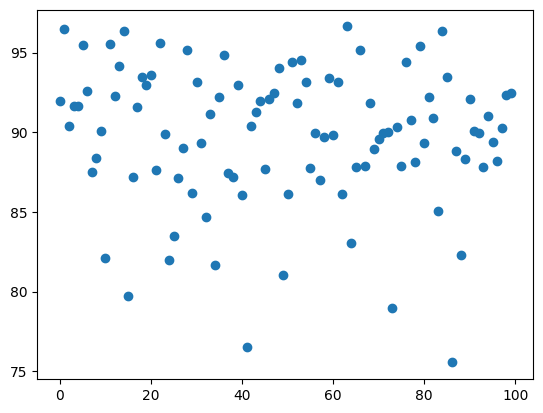

In [59]:
plt.scatter(range(count),alg_results_3/gur_results*100)

In [2]:
import random as rd

In [ ]:
rd.random()